# Classification and Regressşon Trees (CART)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, validation_curve, cross_validate
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor, export_graphviz, export_text
import pickle
import joblib
!pip install pydotplus
import pydotplus
!pip install skompiler
!pip install astor
from skompiler import skompile

# Settings
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)

import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [ ]:
adv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/Hitters[1].csv")
df = adv.copy()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


# General Information About to Dataset

In [ ]:
def check_df(dataframe, head=5):
    print(20*"#", "HEAD", 20*"#")
    print(dataframe.head(head))
    print(20*"#", "TAIL", 20*"#")
    print(dataframe.tail(head))
    print(20*"#", "SHAPE", 20*"#")
    print(dataframe.shape)
    print(20*"#", "TYPES", 20*"#")
    print(dataframe.dtypes)
    print(20*"#", "NA", 20*"#")
    print(dataframe.isnull().sum())
    print(20*"#", "QUARTILES", 20*"#")
    print(dataframe.describe([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).T)

In [ ]:
check_df(df)

#################### HEAD ####################
   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague
0    293    66      1    30   29     14      1     293     66       1     30    29      14      A        E      446       33      20     NaN         A
1    315    81      7    24   38     39     14    3449    835      69    321   414     375      N        W      632       43      10   475.0         N
2    479   130     18    66   72     76      3    1624    457      63    224   266     263      A        W      880       82      14   480.0         A
3    496   141     20    65   78     37     11    5628   1575     225    828   838     354      N        E      200       11       3   500.0         N
4    321    87     10    39   42     30      2     396    101      12     48    46      33      N        E      805       40       4    91.5         N
#################### TAIL ####################


# Analysis of Catgeorical and Numerical Variables

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20, report=False):
    # category
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in  ["category", "object", "bool"]]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(dataframe[col].dtypes) in ["category", "object"]]
    cat_cols = cat_cols + num_but_cat
    # numerical
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]
    # report
    if report:
        print(f"Observation: {dataframe.shape[0]}")
        print(f"Variables: {dataframe.shape[1]}")
        print(f"Categrical Columns: {len(cat_cols)}")
        print(f"Numerical Columns: {len(num_cols)}")
        print(f"Categorical But Cardinality: {len(cat_but_car)}")
        print(f"Numerical But Categorical: {len(num_but_cat)}")
    return cat_cols, num_but_cat, cat_but_car, num_cols

In [ ]:
cat_cols, num_but_cat, cat_but_car, num_cols = grab_col_names(df, report=True)

Observation: 322
Variables: 20
Categrical Columns: 3
Numerical Columns: 17
Categorical But Cardinality: 0
Numerical But Categorical: 0


In [ ]:
def num_summary(dataframe, col_name, plot=False):
    print(20*"#", col_name, 20*"#")
    quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)
    if plot:
        dataframe[col_name].hist(bins=20)
        plt.xlabel(col_name)
        plt.ylabel(col_name)
        plt.show()

In [ ]:
def num_summary_df(dataframe):
    cat_cols, num_but_cat, cat_but_car, num_cols = grab_col_names(dataframe)
    for col in num_cols:
        num_summary(dataframe, col, plot=True)

#################### AtBat ####################
count    322.000000
mean     380.928571
std      153.404981
min       16.000000
1%        20.420000
5%       161.000000
10%      194.100000
20%      221.800000
30%      281.300000
40%      321.800000
50%      379.500000
60%      430.200000
70%      490.000000
80%      535.600000
90%      584.900000
95%      609.900000
99%      658.590000
max      687.000000
Name: AtBat, dtype: float64


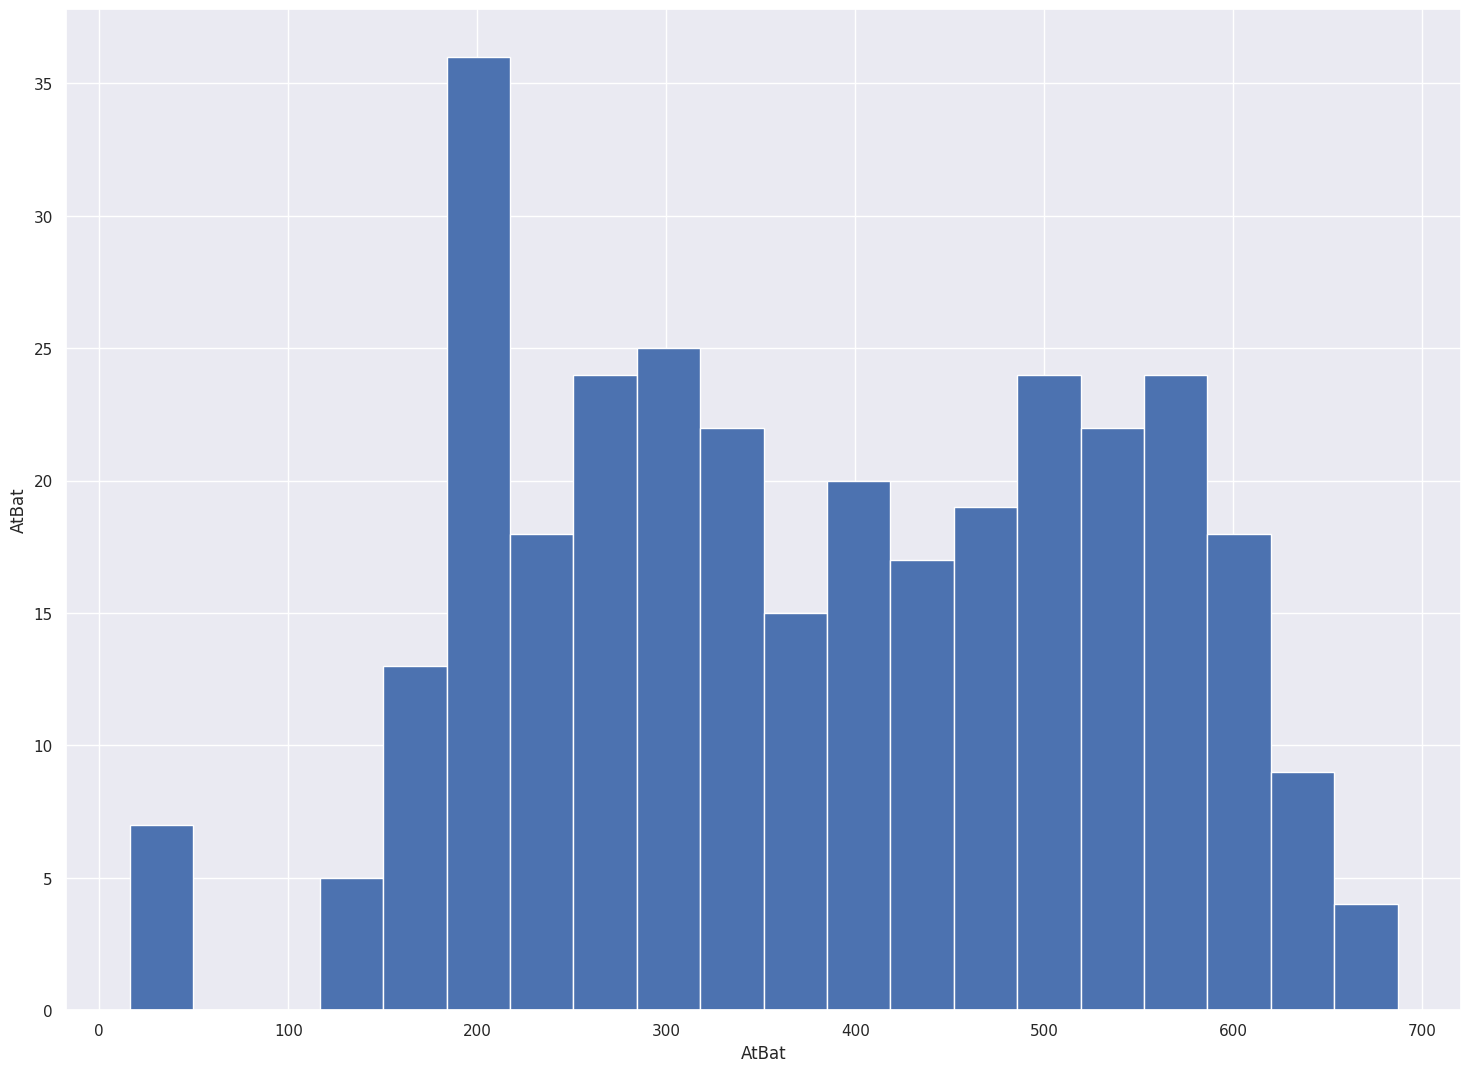

#################### Hits ####################
count    322.000000
mean     101.024845
std       46.454741
min        1.000000
1%         4.420000
5%        39.000000
10%       45.100000
20%       57.000000
30%       70.000000
40%       82.000000
50%       96.000000
60%      113.000000
70%      128.700000
80%      144.000000
90%      163.000000
95%      174.000000
99%      210.790000
max      238.000000
Name: Hits, dtype: float64


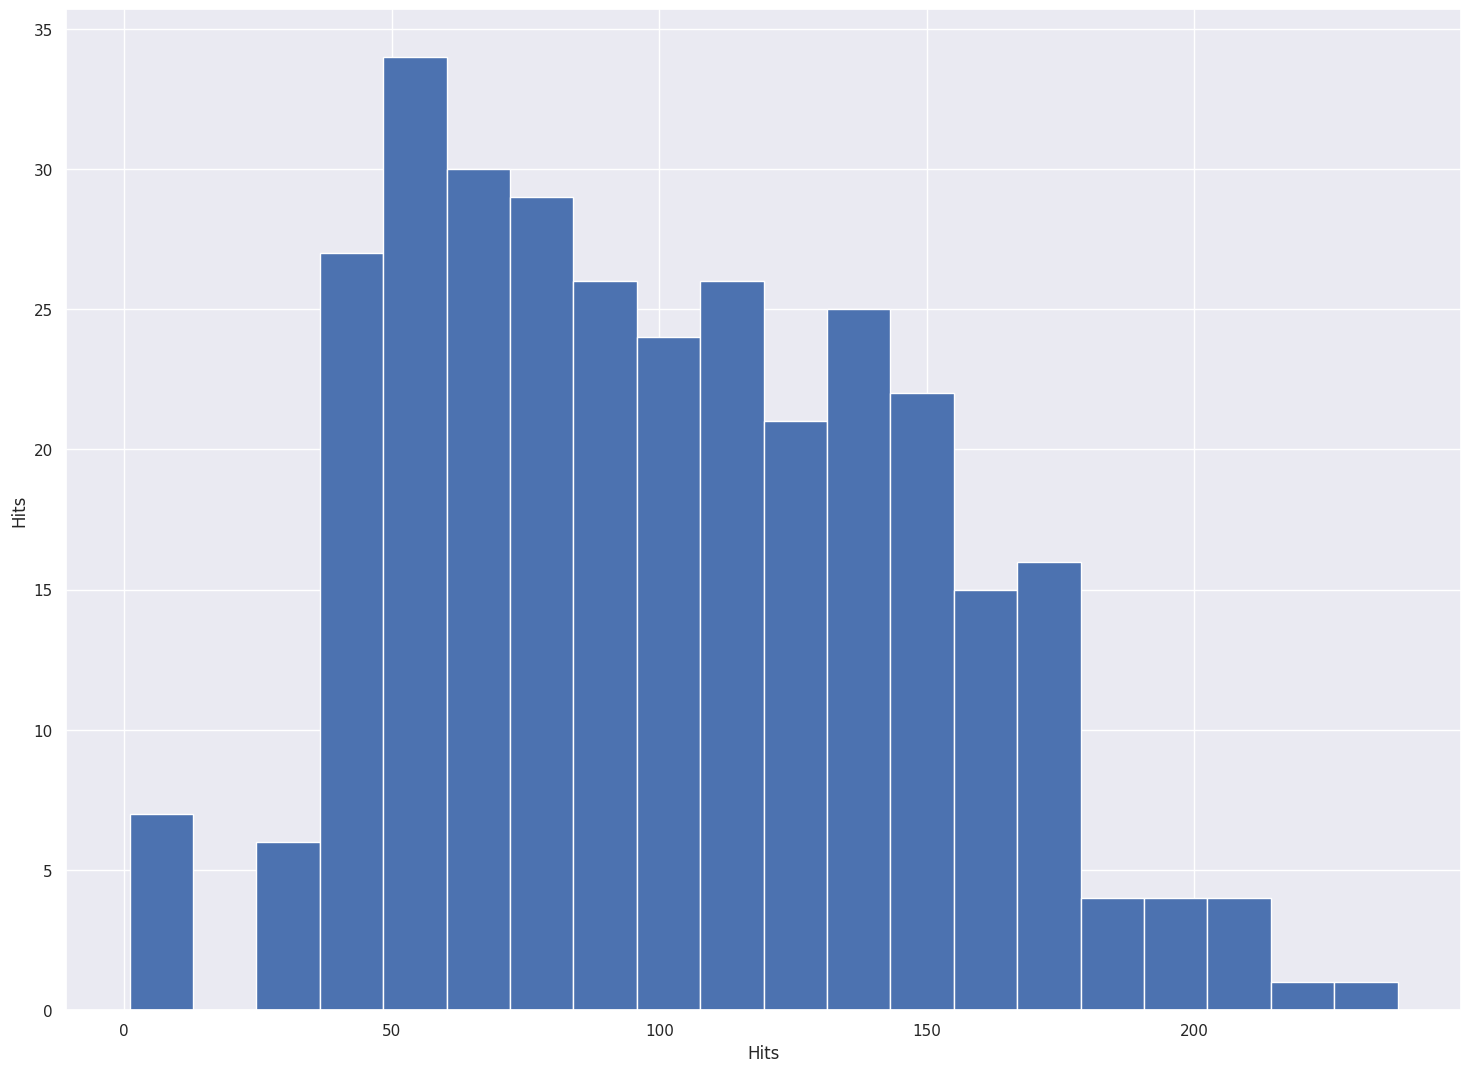

#################### HmRun ####################
count    322.000000
mean      10.770186
std        8.709037
min        0.000000
1%         0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        5.000000
40%        6.000000
50%        8.000000
60%       10.600000
70%       14.000000
80%       18.000000
90%       24.000000
95%       28.950000
99%       33.000000
max       40.000000
Name: HmRun, dtype: float64


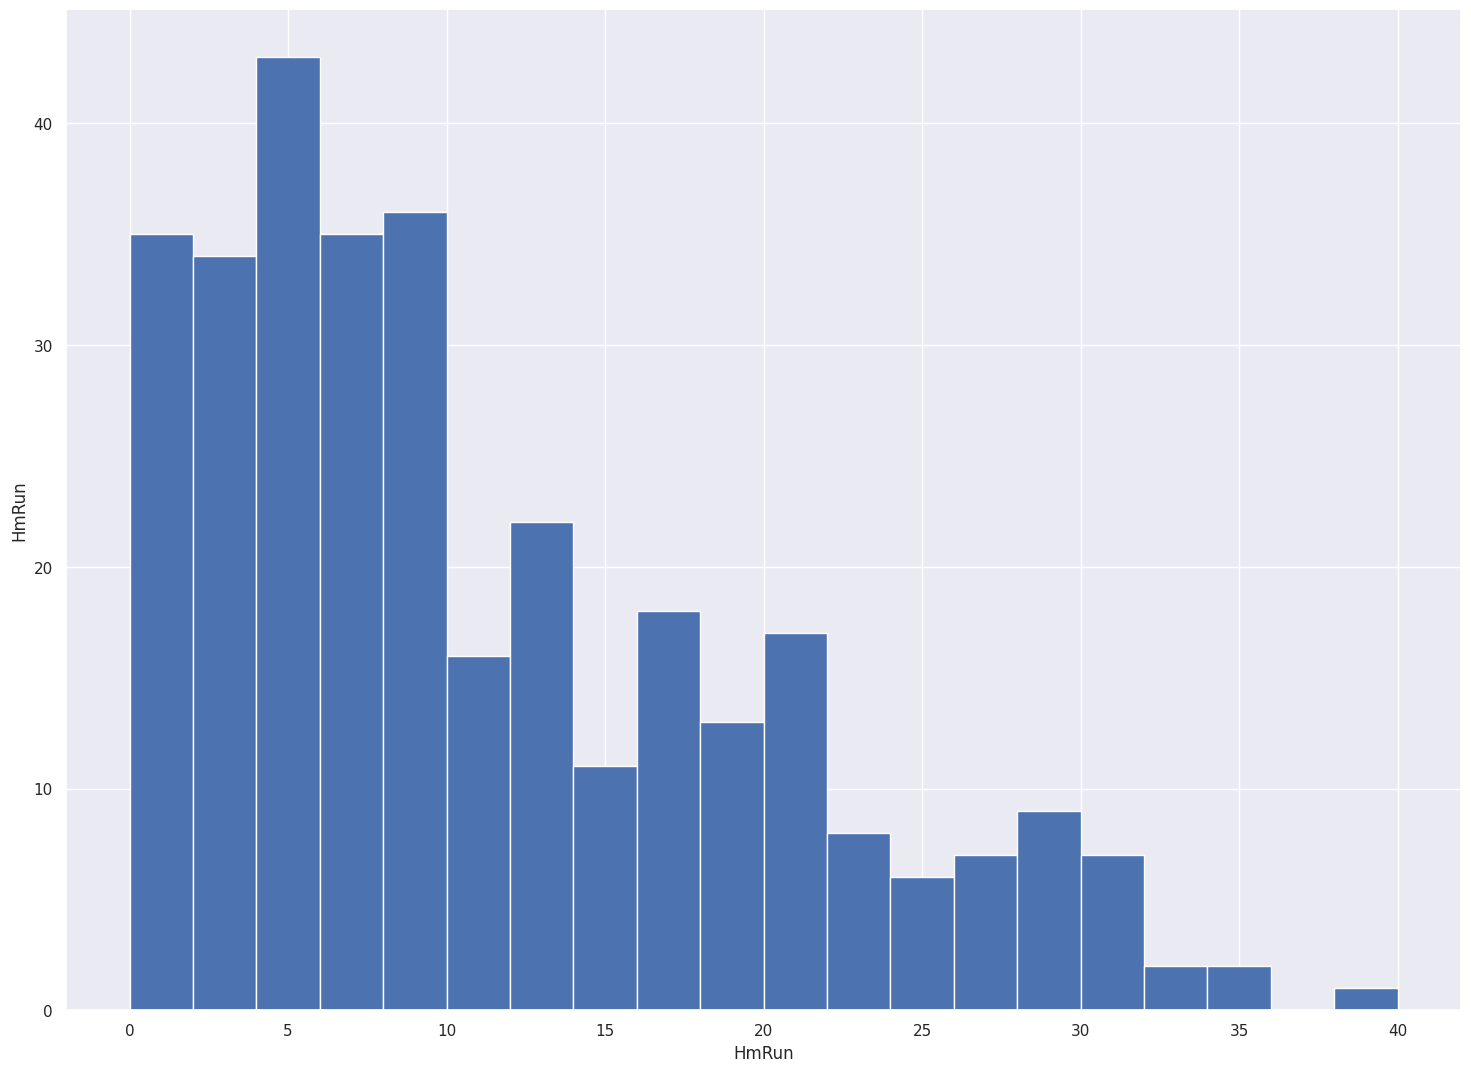

#################### Runs ####################
count    322.000000
mean      50.909938
std       26.024095
min        0.000000
1%         1.210000
5%        17.000000
10%       20.100000
20%       27.000000
30%       33.000000
40%       41.000000
50%       48.000000
60%       55.600000
70%       66.000000
80%       75.800000
90%       89.000000
95%       94.000000
99%      107.790000
max      130.000000
Name: Runs, dtype: float64


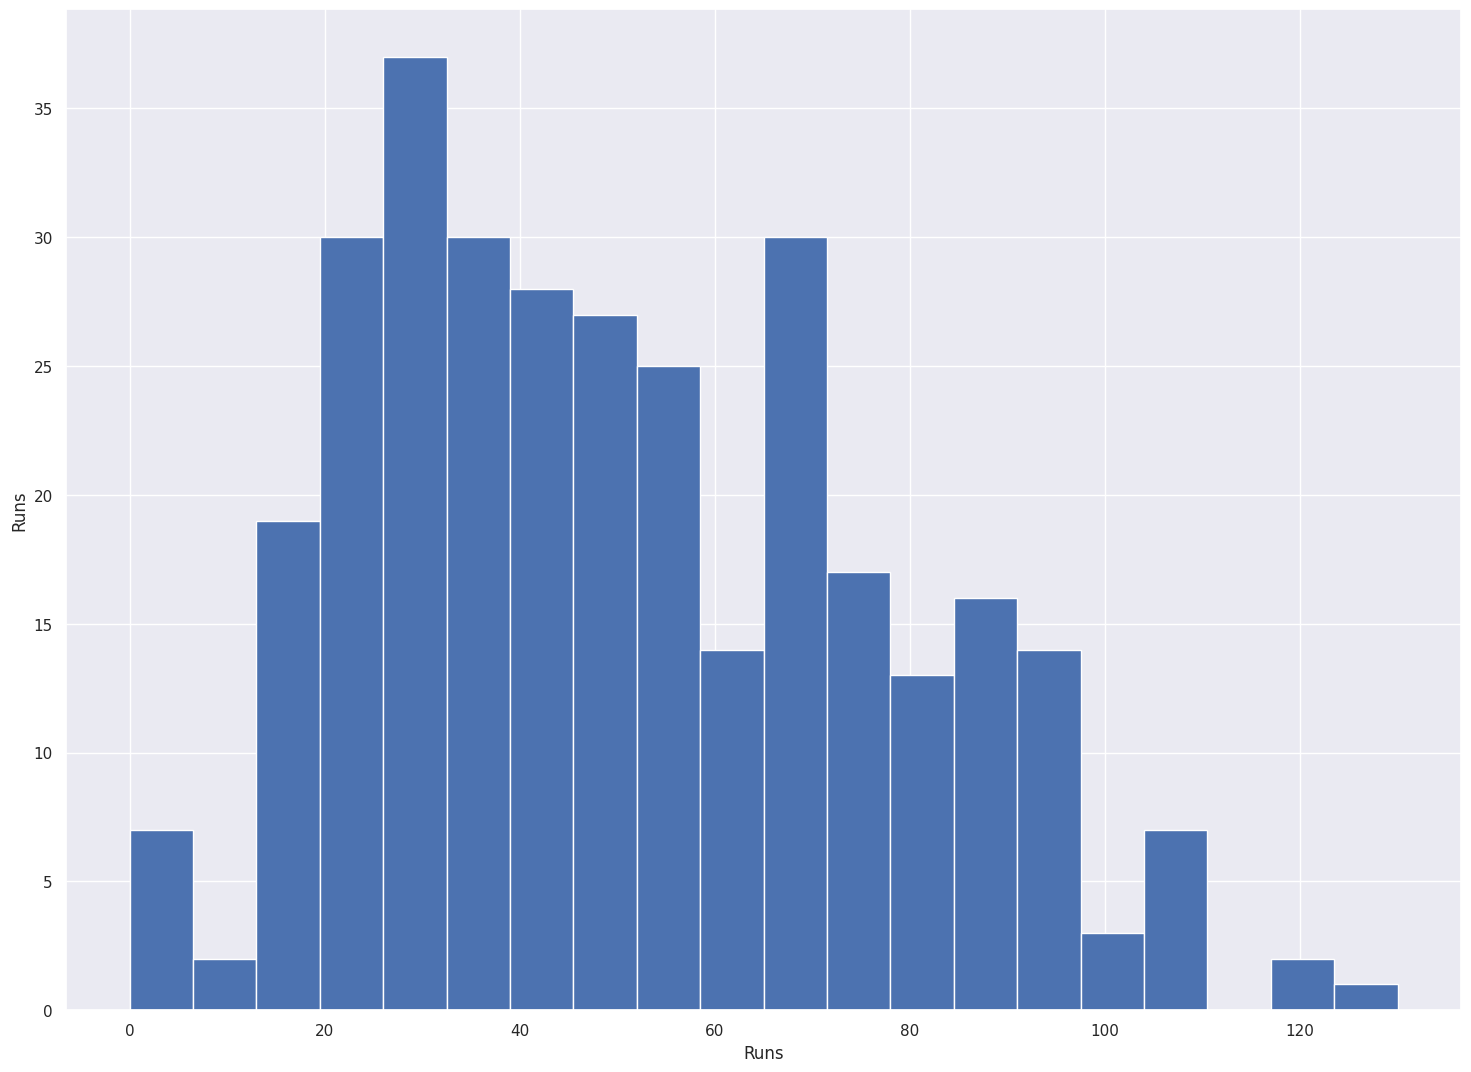

#################### RBI ####################
count    322.000000
mean      48.027950
std       26.166895
min        0.000000
1%         2.000000
5%        14.000000
10%       19.000000
20%       26.000000
30%       30.000000
40%       36.400000
50%       44.000000
60%       49.000000
70%       58.000000
80%       73.000000
90%       86.000000
95%       96.000000
99%      112.370000
max      121.000000
Name: RBI, dtype: float64


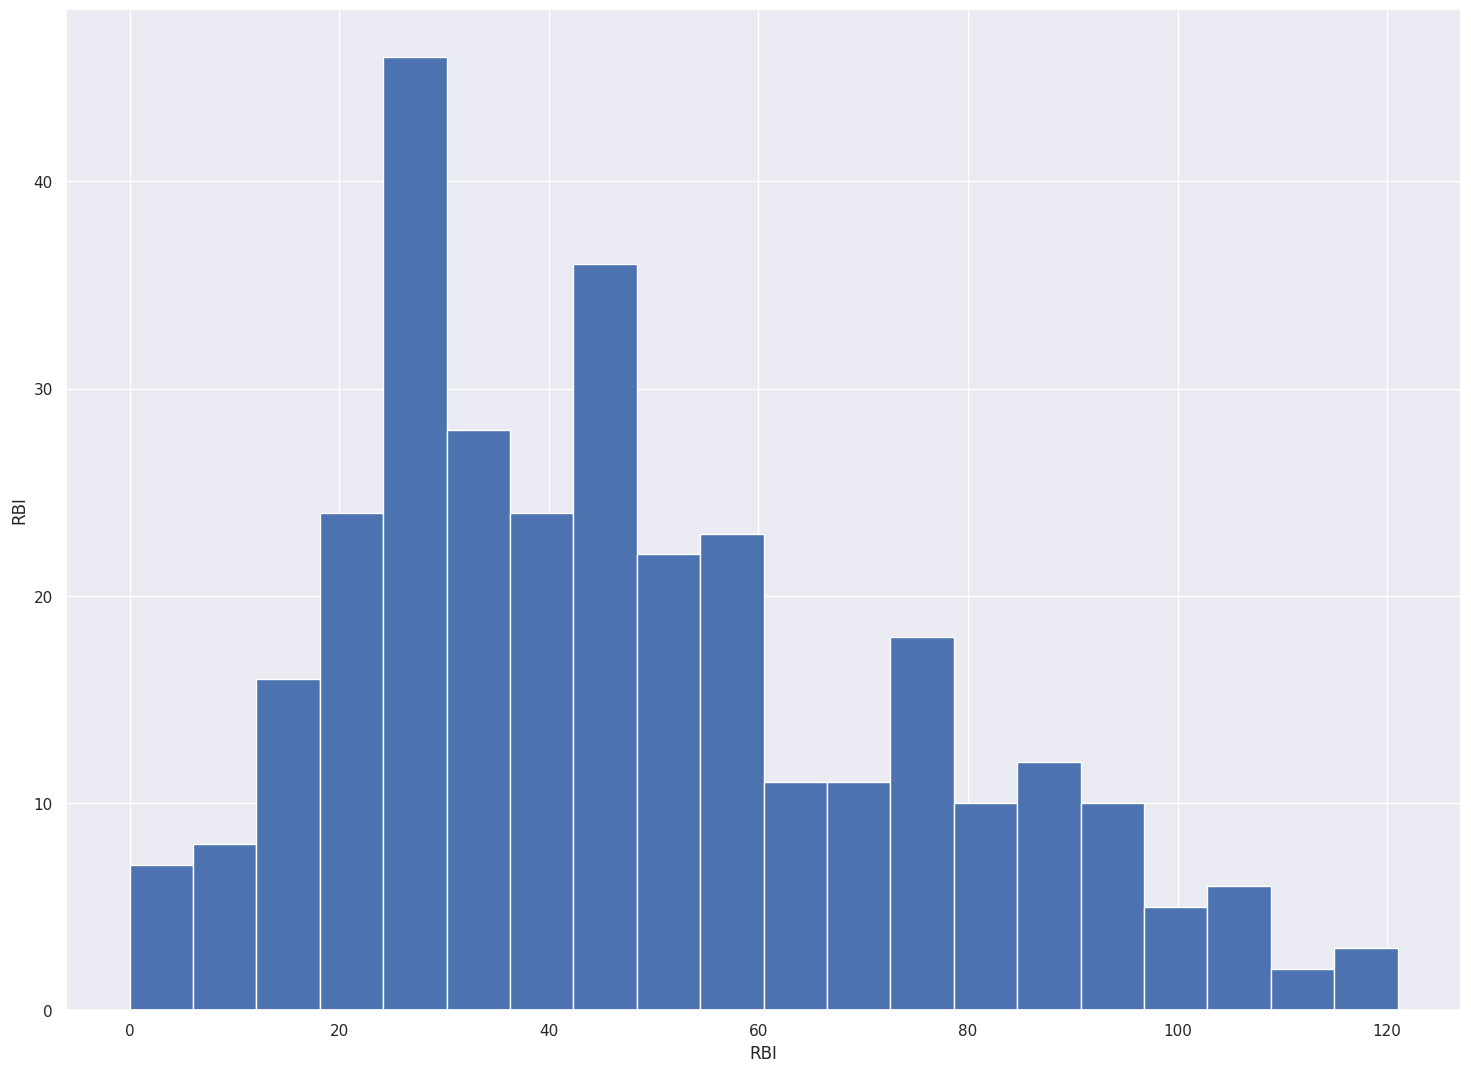

#################### Walks ####################
count    322.000000
mean      38.742236
std       21.639327
min        0.000000
1%         1.000000
5%        11.050000
10%       15.000000
20%       20.000000
30%       24.000000
40%       30.000000
50%       35.000000
60%       40.000000
70%       48.700000
80%       59.000000
90%       69.900000
95%       78.000000
99%       93.580000
max      105.000000
Name: Walks, dtype: float64


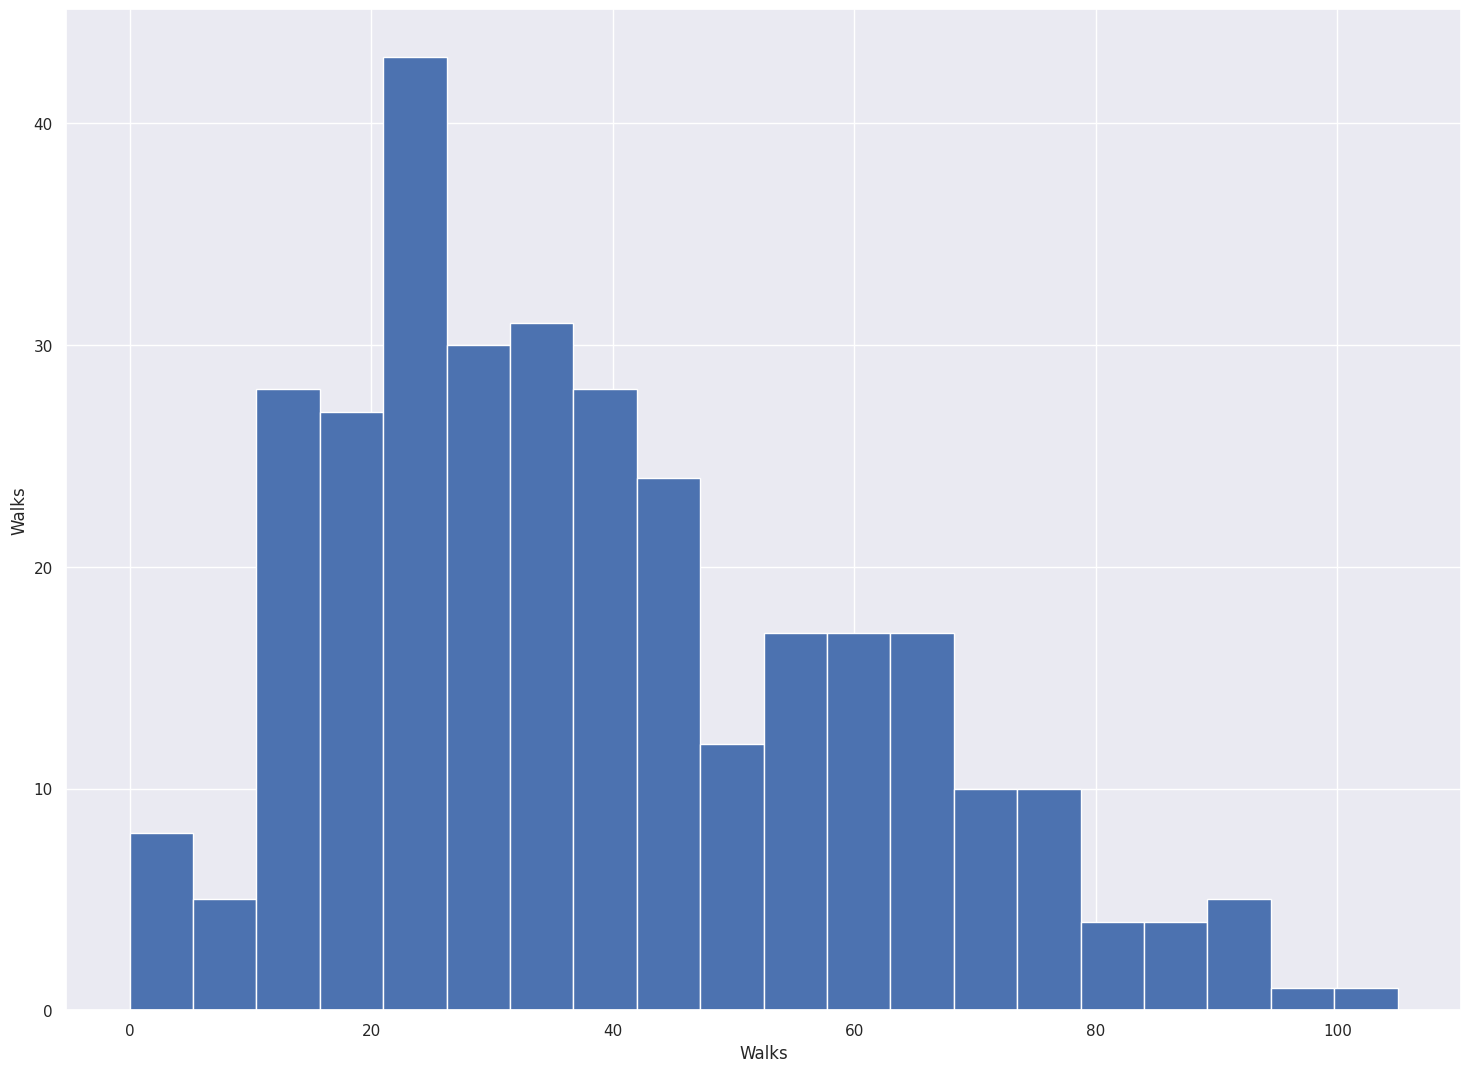

#################### Years ####################
count    322.000000
mean       7.444099
std        4.926087
min        1.000000
1%         1.000000
5%         1.000000
10%        2.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        7.600000
70%       10.000000
80%       12.000000
90%       15.000000
95%       17.000000
99%       19.790000
max       24.000000
Name: Years, dtype: float64


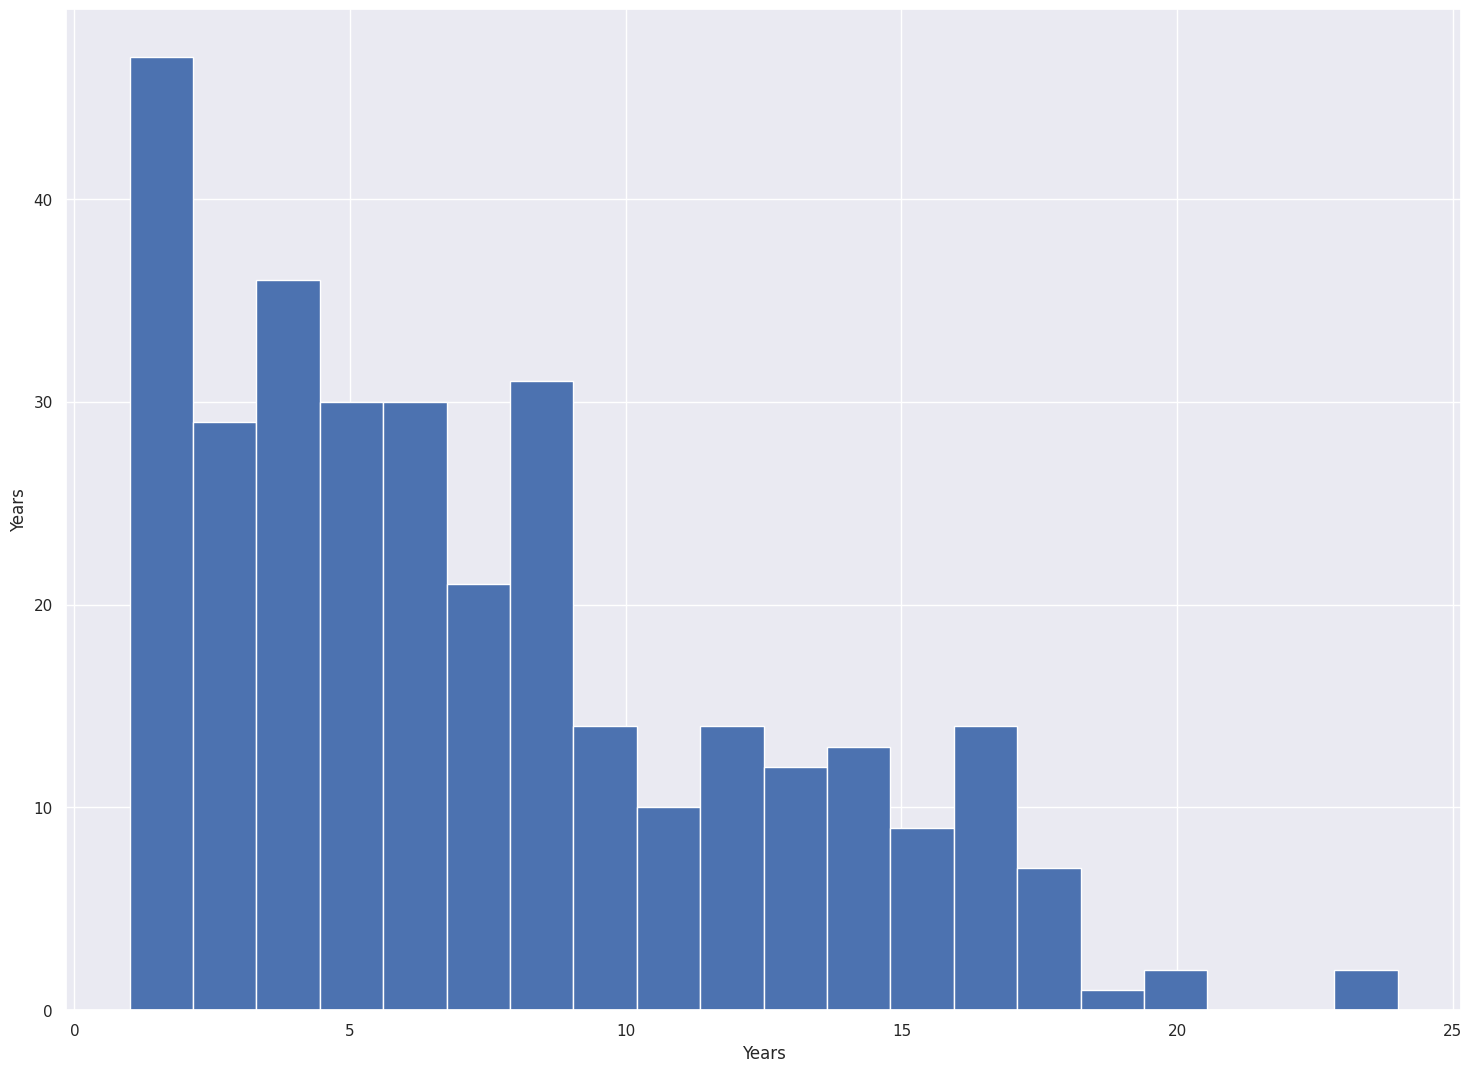

#################### CAtBat ####################
count      322.00000
mean      2648.68323
std       2324.20587
min         19.00000
1%          41.00000
5%         216.50000
10%        342.20000
20%        667.60000
30%        963.40000
40%       1402.20000
50%       1928.00000
60%       2654.00000
70%       3365.00000
80%       4483.00000
90%       6123.40000
95%       7125.60000
99%       8749.97000
max      14053.00000
Name: CAtBat, dtype: float64


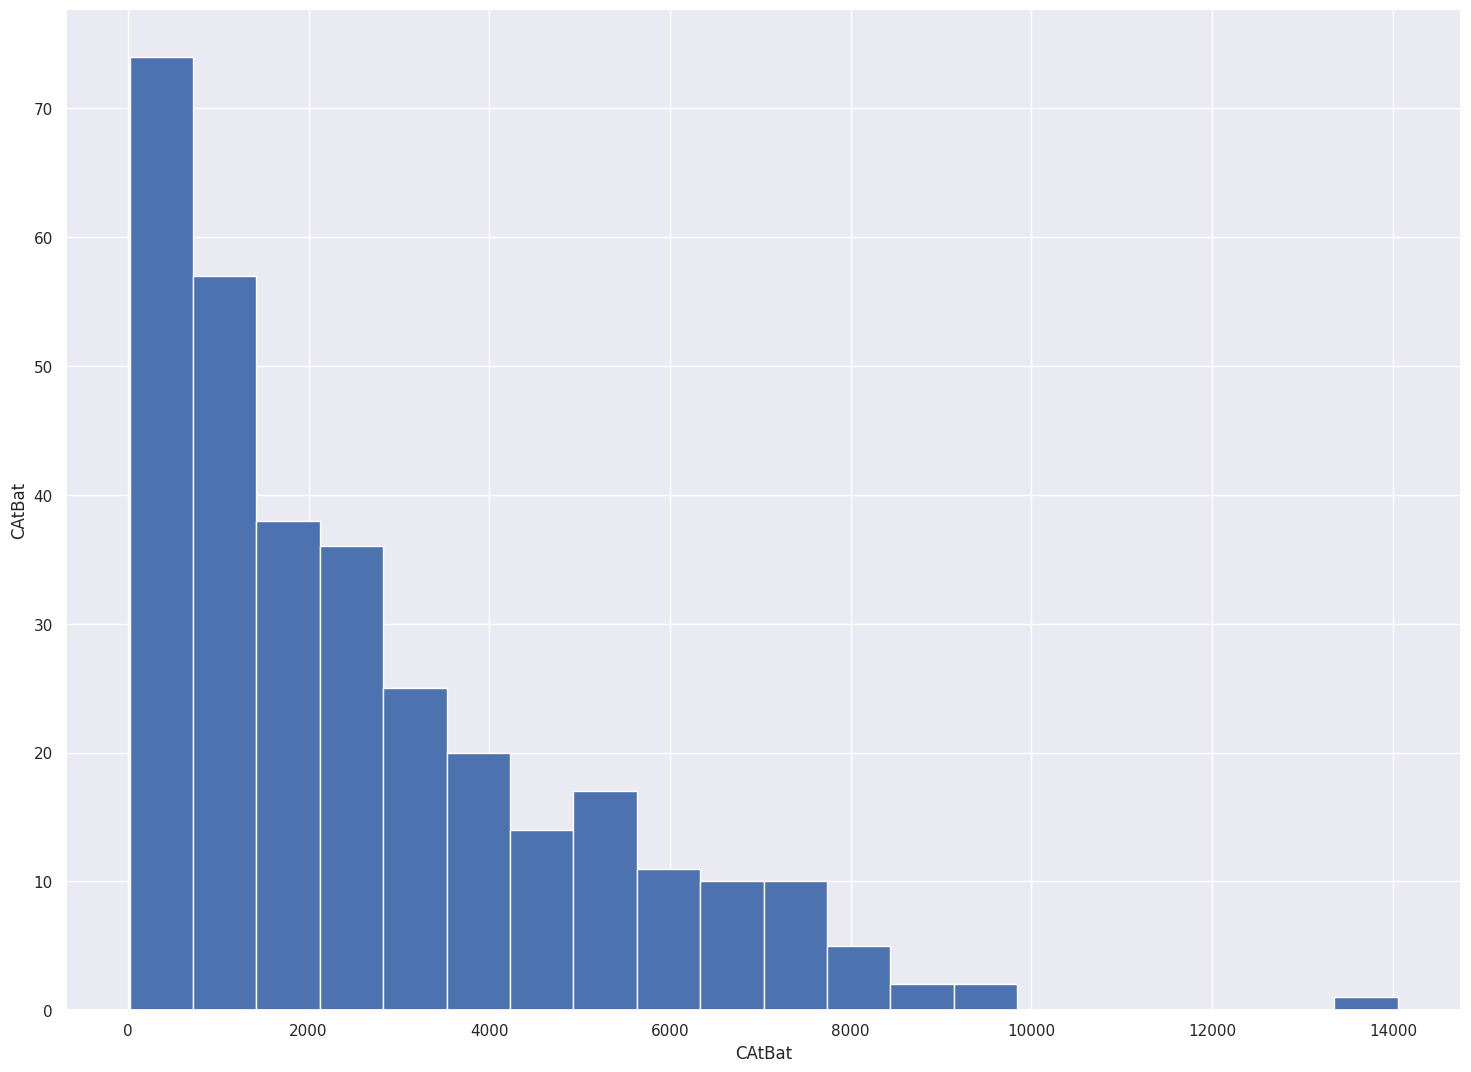

#################### CHits ####################
count     322.000000
mean      717.571429
std       654.472627
min         4.000000
1%          9.840000
5%         54.000000
10%        86.000000
20%       164.600000
30%       238.000000
40%       355.800000
50%       508.000000
60%       708.200000
70%       911.100000
80%      1229.200000
90%      1659.600000
95%      2017.150000
99%      2500.340000
max      4256.000000
Name: CHits, dtype: float64


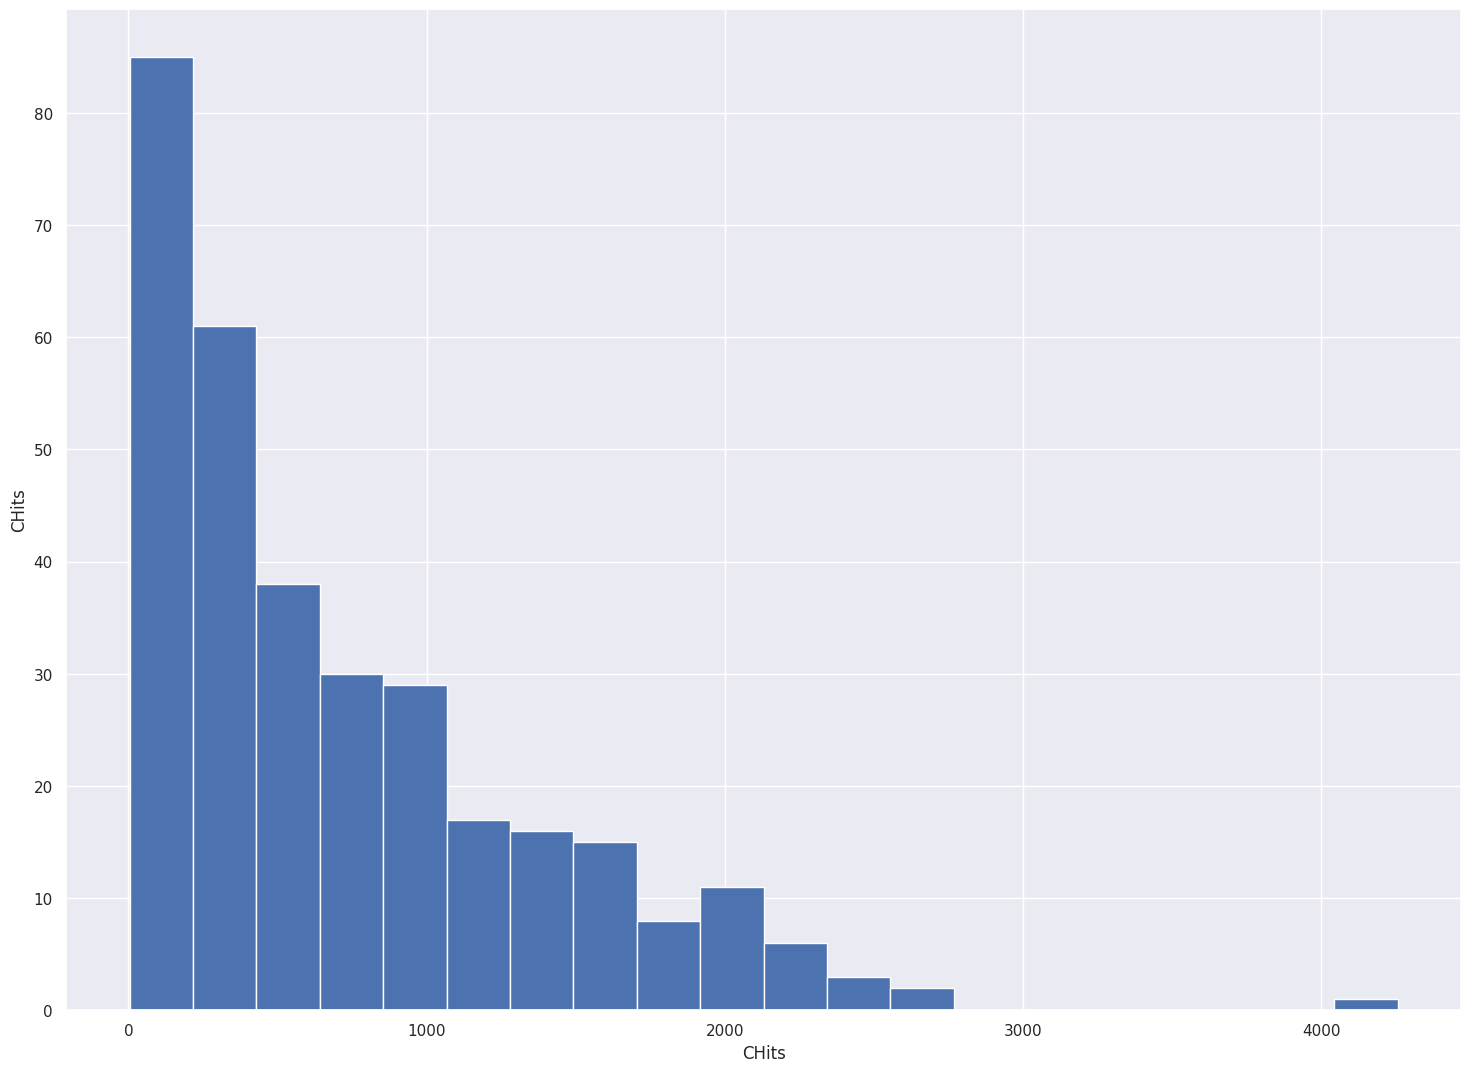

#################### CHmRun ####################
count    322.000000
mean      69.490683
std       86.266061
min        0.000000
1%         0.000000
5%         2.000000
10%        4.000000
20%       10.200000
30%       16.300000
40%       27.400000
50%       37.500000
60%       51.200000
70%       72.400000
80%      103.800000
90%      194.900000
95%      265.650000
99%      373.120000
max      548.000000
Name: CHmRun, dtype: float64


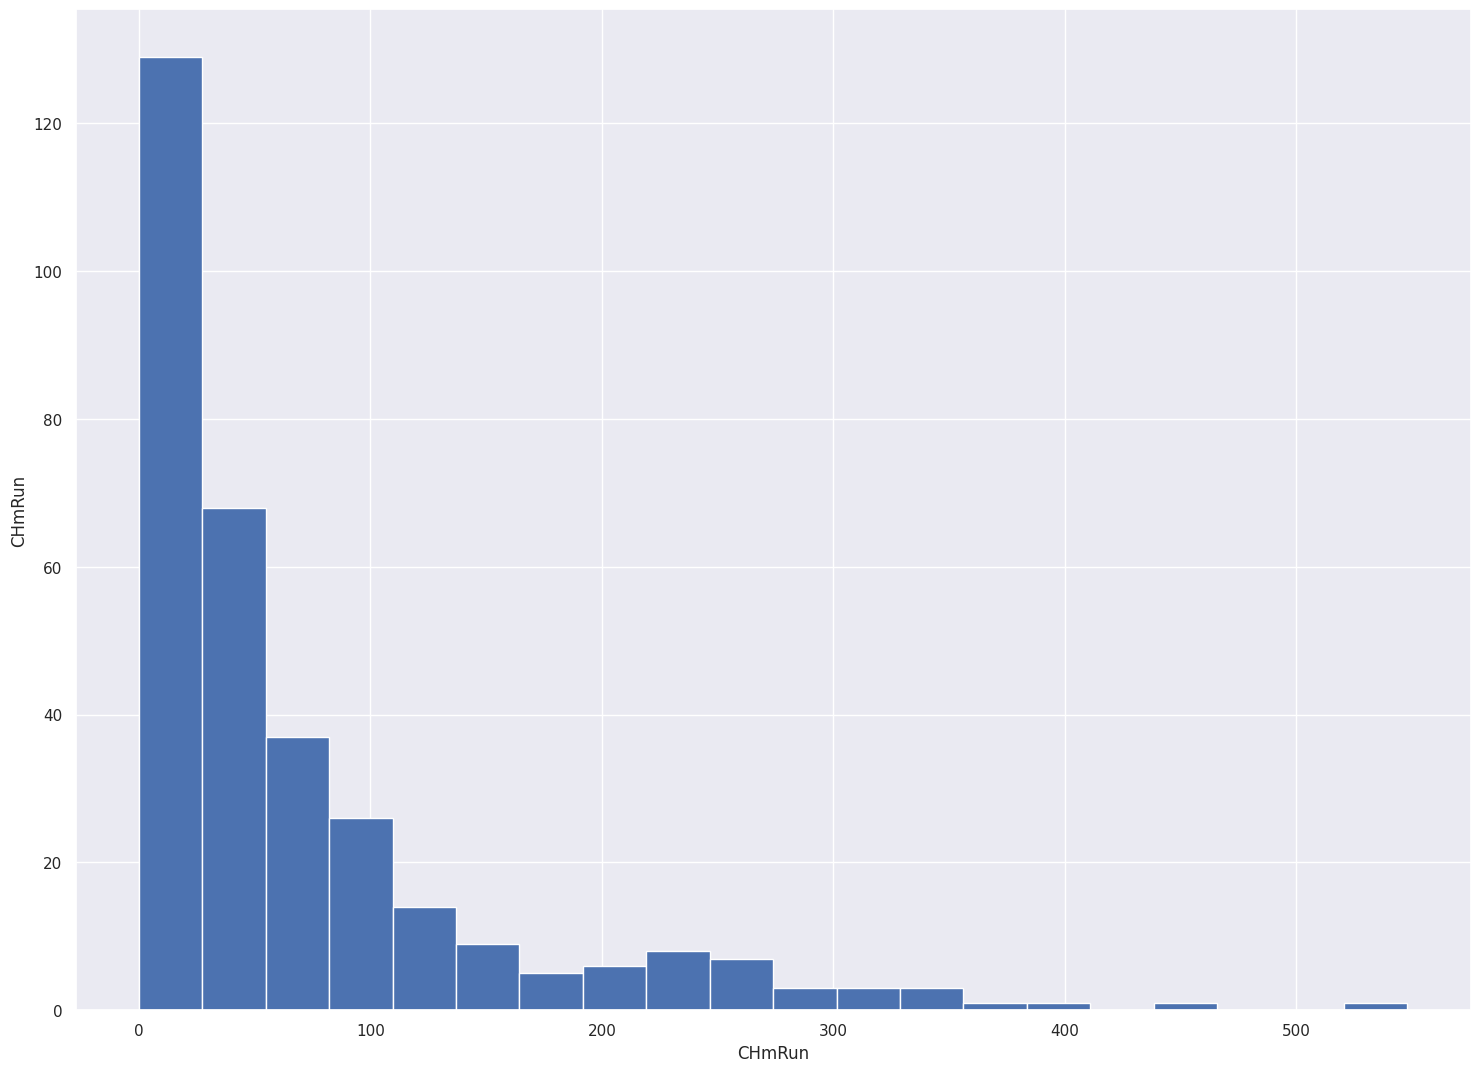

#################### CRuns ####################
count     322.000000
mean      358.795031
std       334.105886
min         1.000000
1%          3.630000
5%         27.000000
10%        38.100000
20%        80.400000
30%       117.300000
40%       181.000000
50%       247.000000
60%       333.000000
70%       443.400000
80%       627.200000
90%       895.700000
95%      1032.300000
99%      1174.370000
max      2165.000000
Name: CRuns, dtype: float64


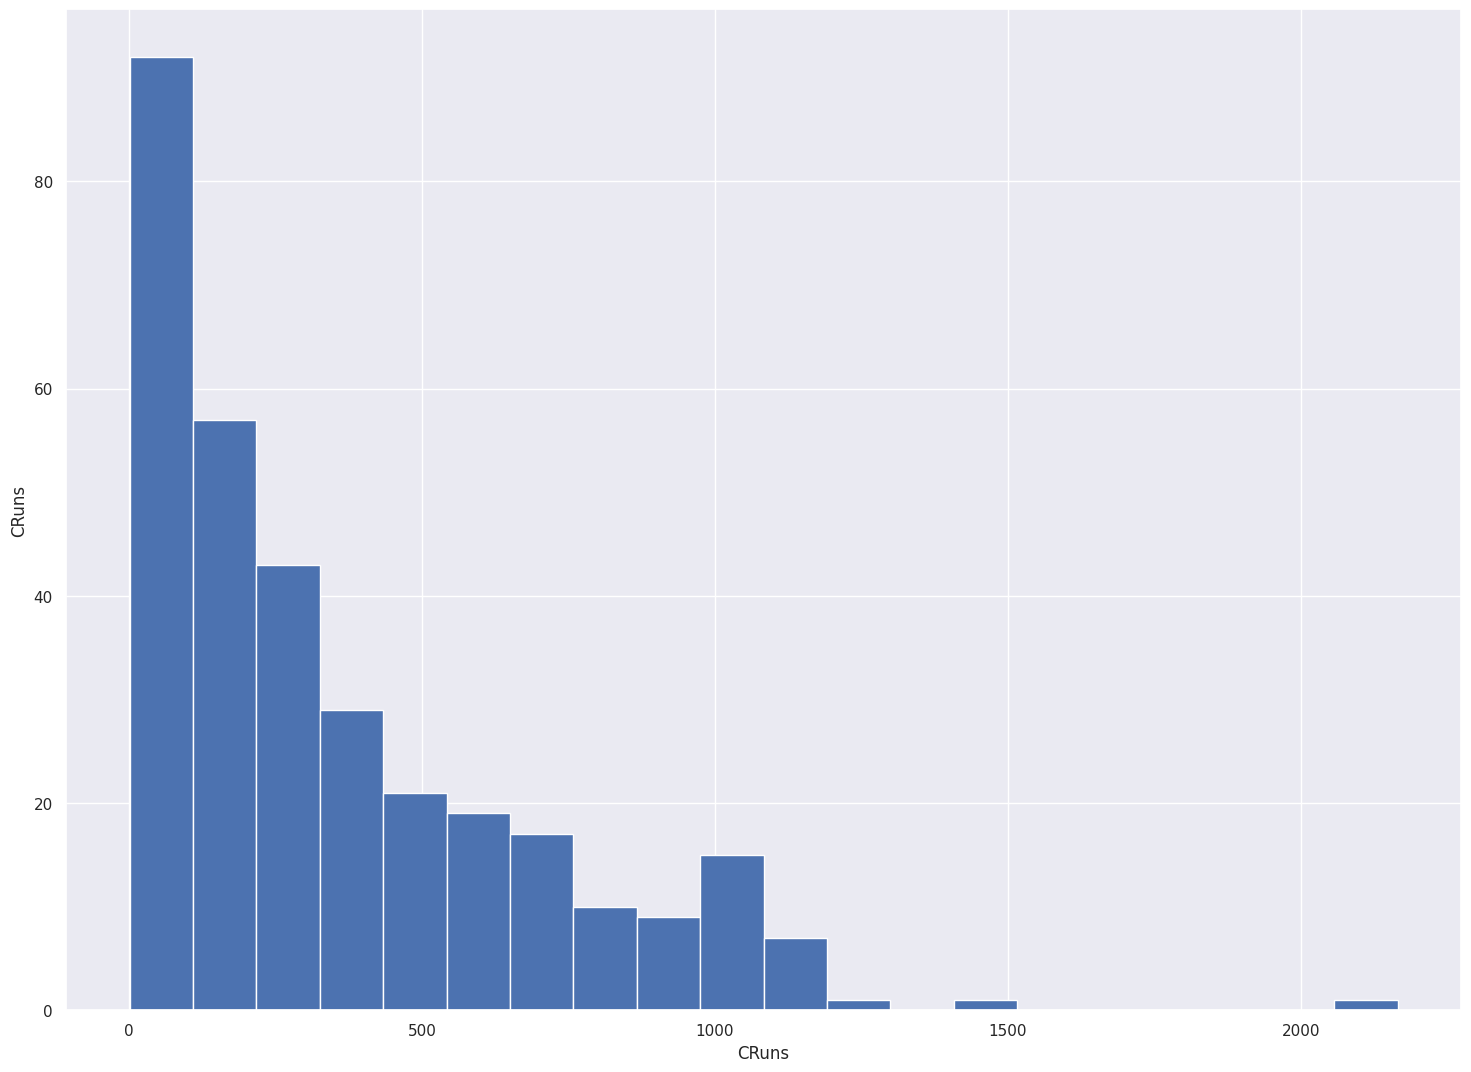

#################### CRBI ####################
count     322.000000
mean      330.118012
std       333.219617
min         0.000000
1%          4.630000
5%         22.050000
10%        34.100000
20%        70.200000
30%       106.300000
40%       149.000000
50%       220.500000
60%       303.600000
70%       379.100000
80%       496.200000
90%       861.600000
95%      1071.750000
99%      1310.850000
max      1659.000000
Name: CRBI, dtype: float64


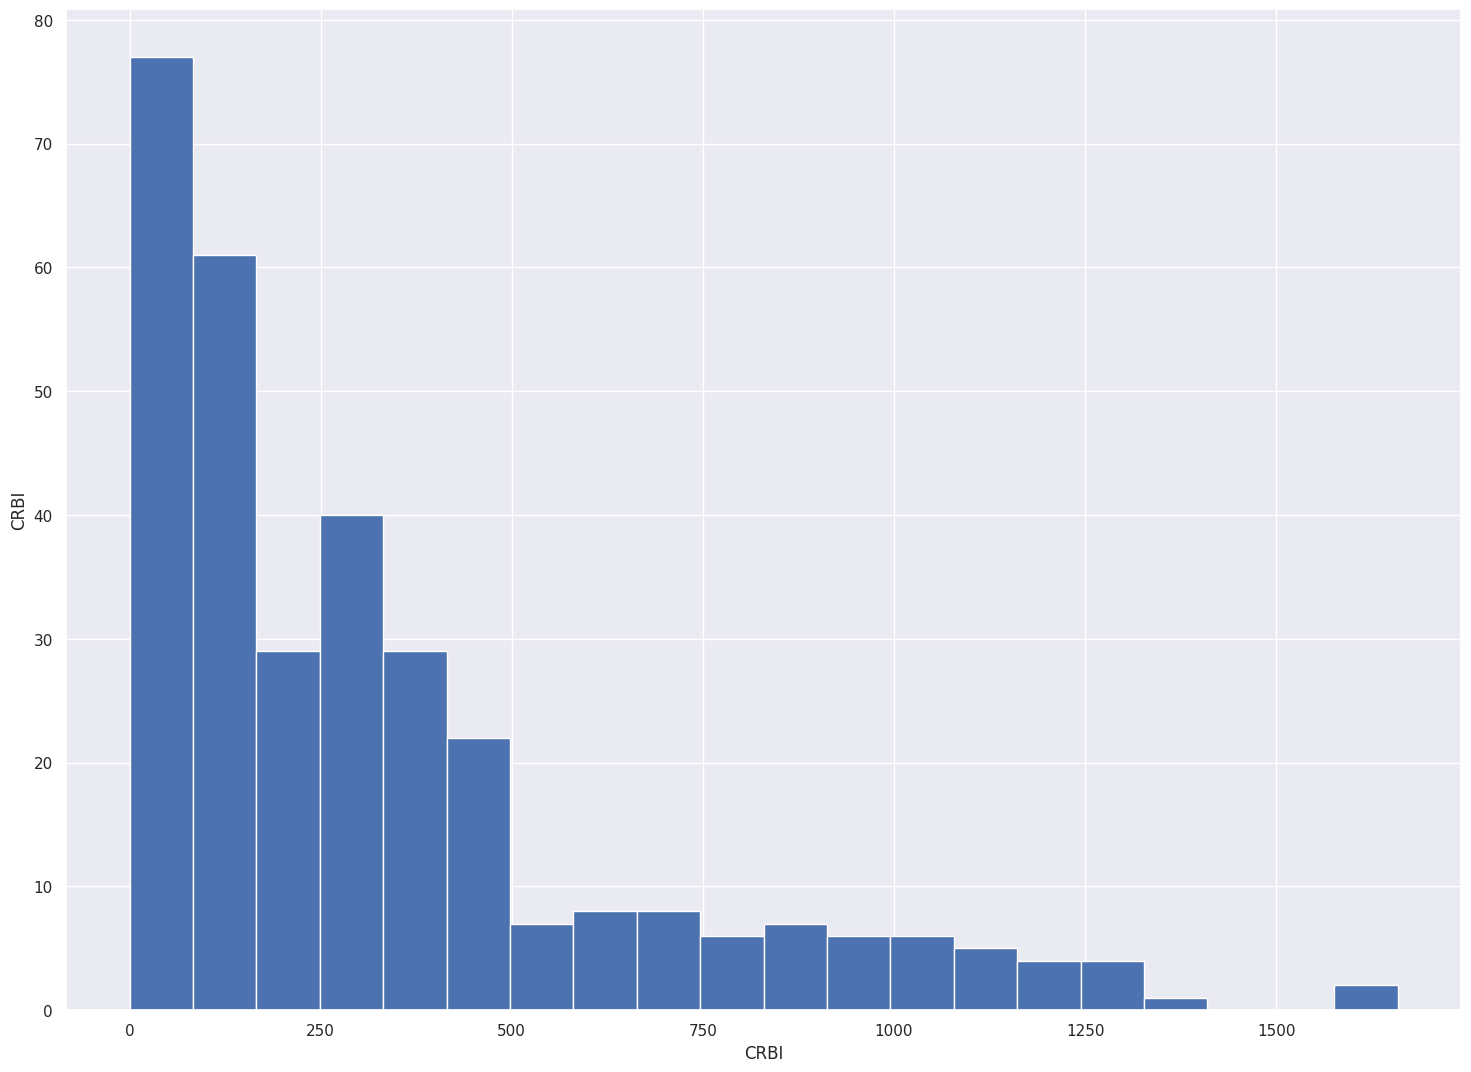

#################### CWalks ####################
count     322.000000
mean      260.239130
std       267.058085
min         0.000000
1%          4.000000
5%         15.050000
10%        30.100000
20%        55.000000
30%        82.000000
40%       117.400000
50%       170.500000
60%       226.600000
70%       300.700000
80%       421.000000
90%       643.900000
95%       817.600000
99%      1139.140000
max      1566.000000
Name: CWalks, dtype: float64


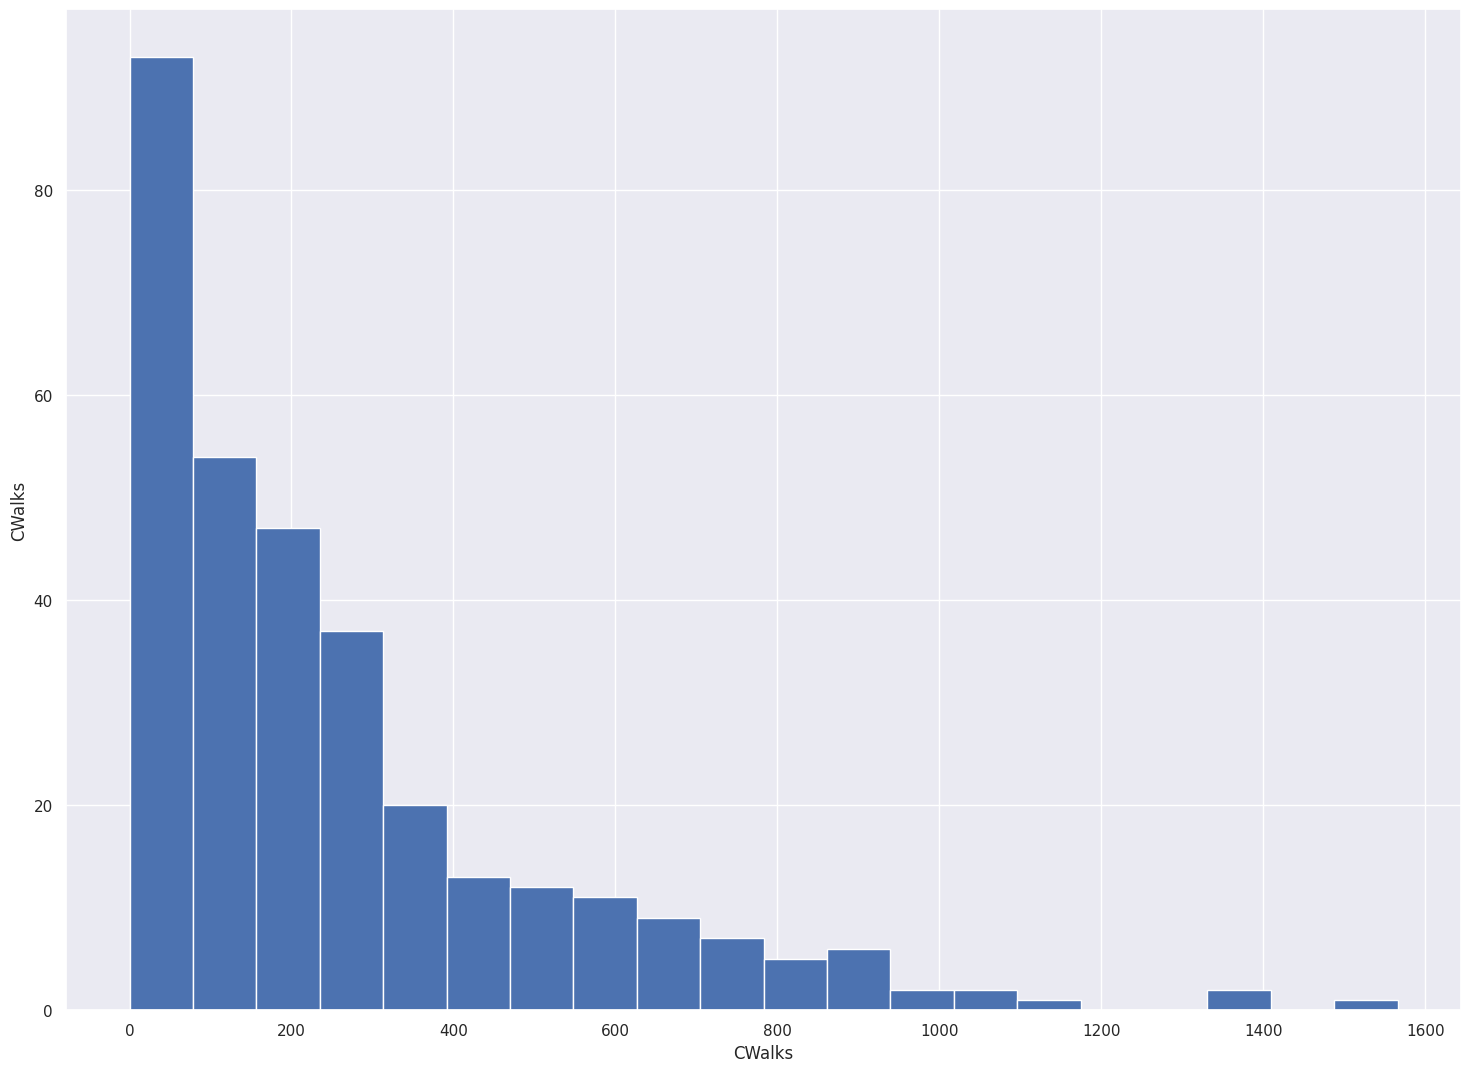

#################### PutOuts ####################
count     322.000000
mean      288.937888
std       280.704614
min         0.000000
1%          0.000000
5%         33.200000
10%        62.200000
20%        99.600000
30%       132.000000
40%       167.000000
50%       212.000000
60%       257.400000
70%       303.000000
80%       365.800000
90%       685.600000
95%       910.650000
99%      1301.190000
max      1378.000000
Name: PutOuts, dtype: float64


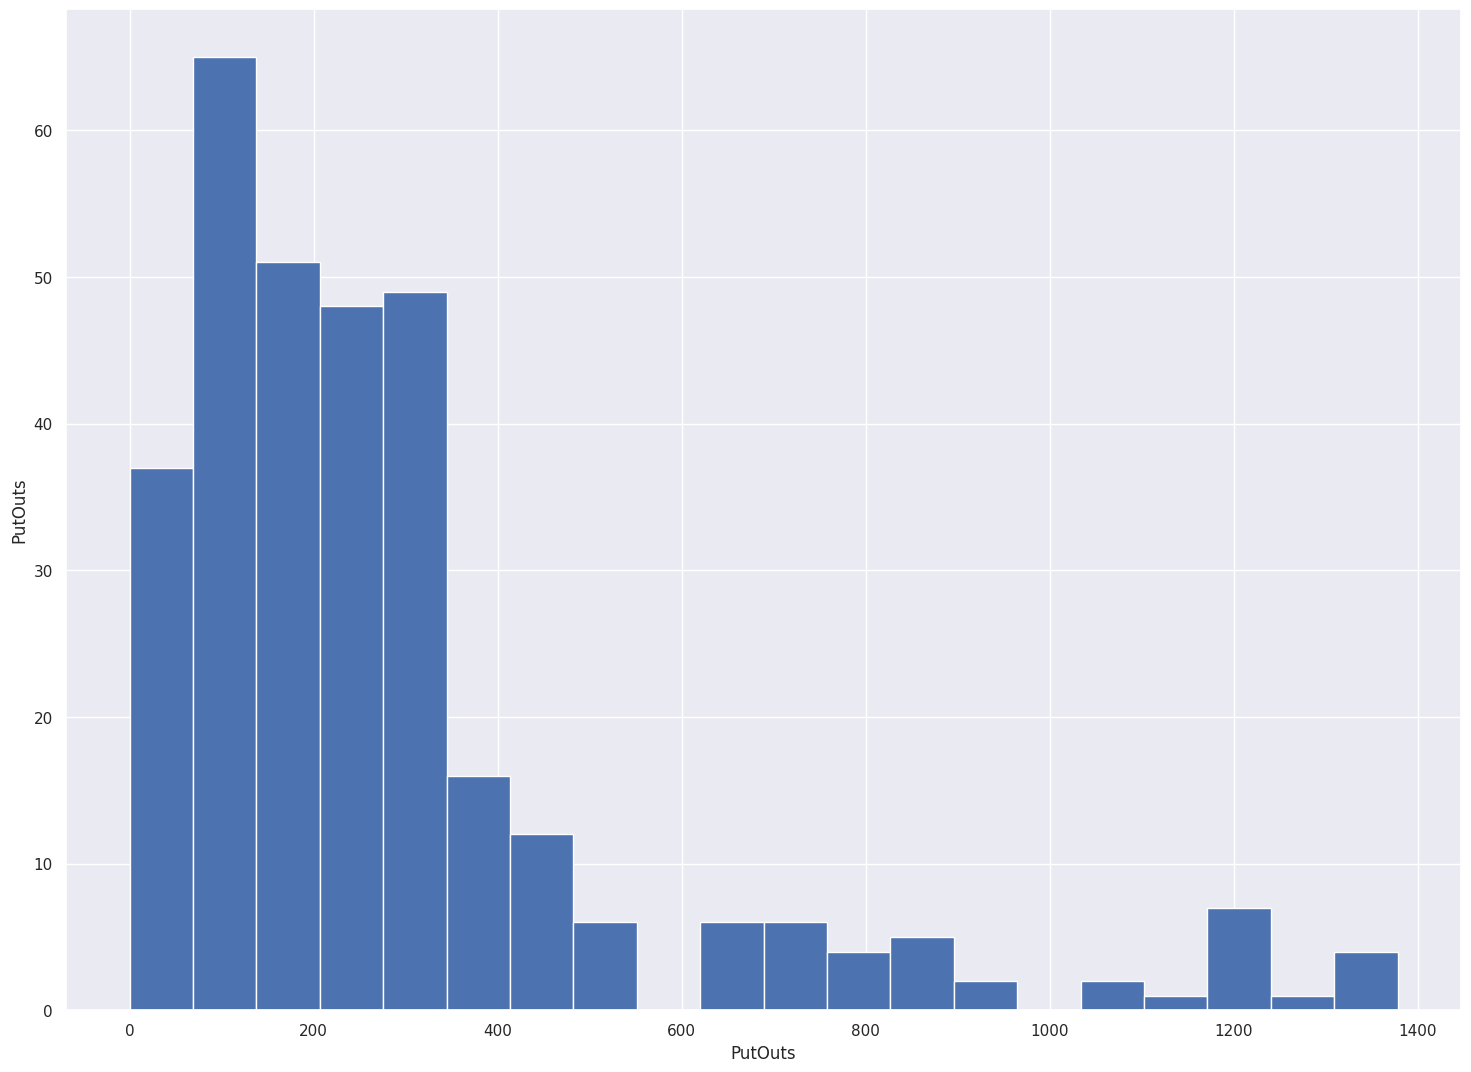

#################### Assists ####################
count    322.000000
mean     106.913043
std      136.854876
min        0.000000
1%         0.000000
5%         0.000000
10%        2.000000
20%        5.200000
30%        9.000000
40%       15.400000
50%       39.500000
60%       76.800000
70%      134.800000
80%      210.800000
90%      353.300000
95%      431.450000
99%      478.160000
max      492.000000
Name: Assists, dtype: float64


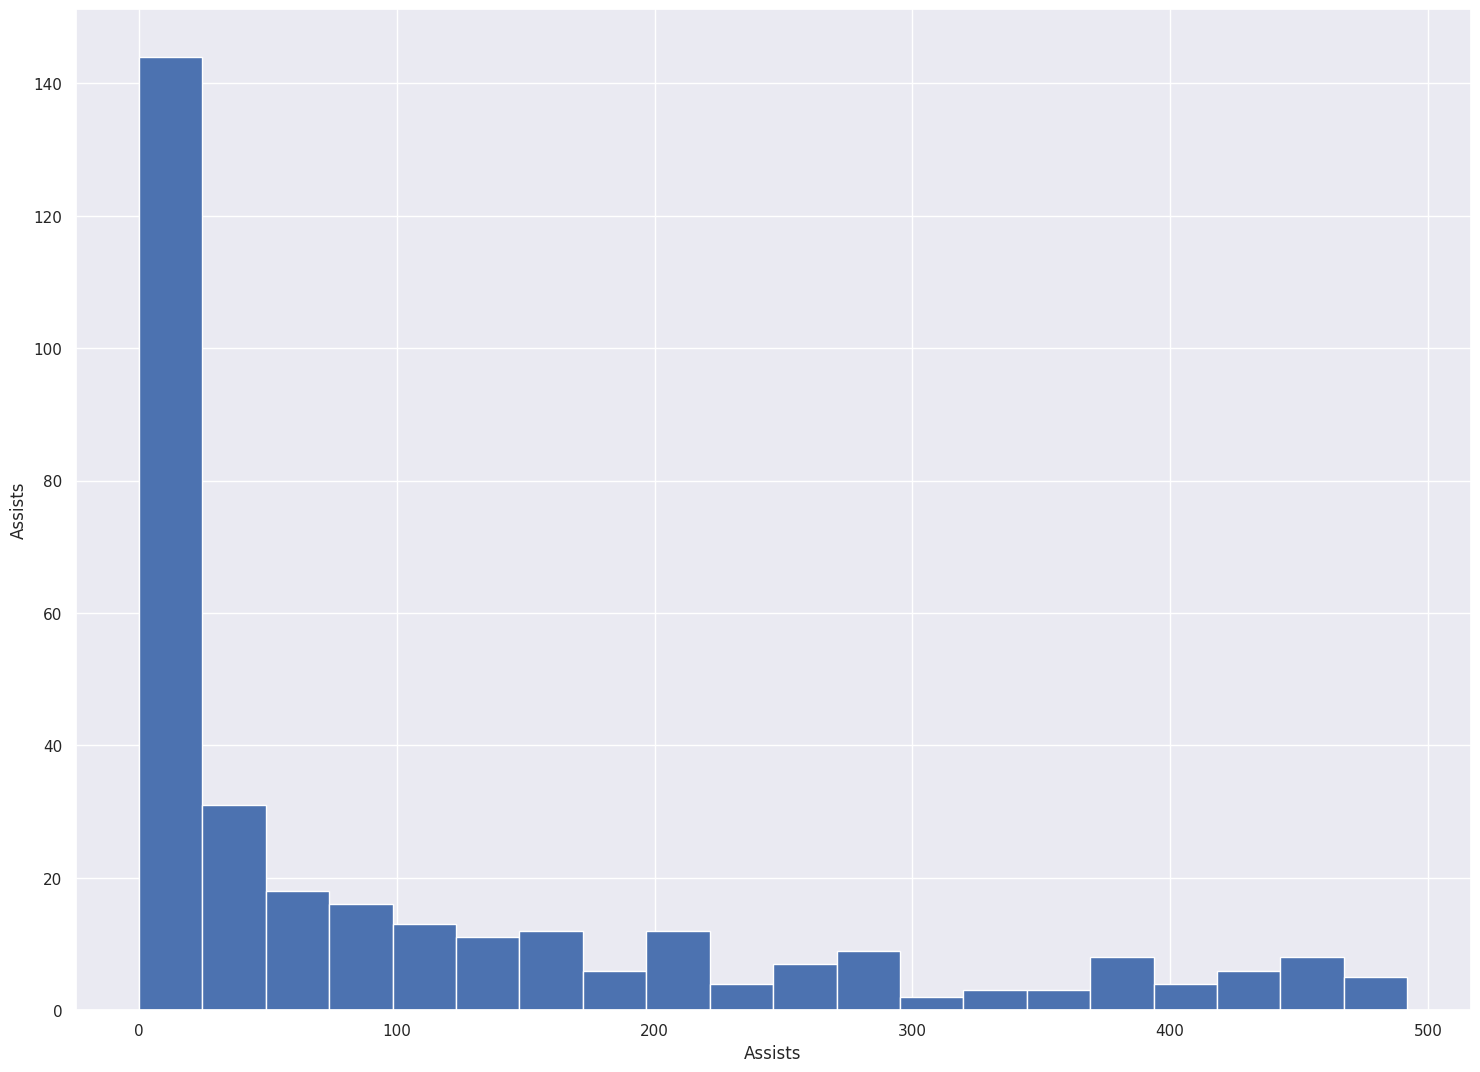

#################### Errors ####################
count    322.000000
mean       8.040373
std        6.368359
min        0.000000
1%         0.000000
5%         0.000000
10%        1.000000
20%        3.000000
30%        4.000000
40%        5.000000
50%        6.000000
60%        8.000000
70%       10.000000
80%       13.000000
90%       17.000000
95%       20.000000
99%       25.790000
max       32.000000
Name: Errors, dtype: float64


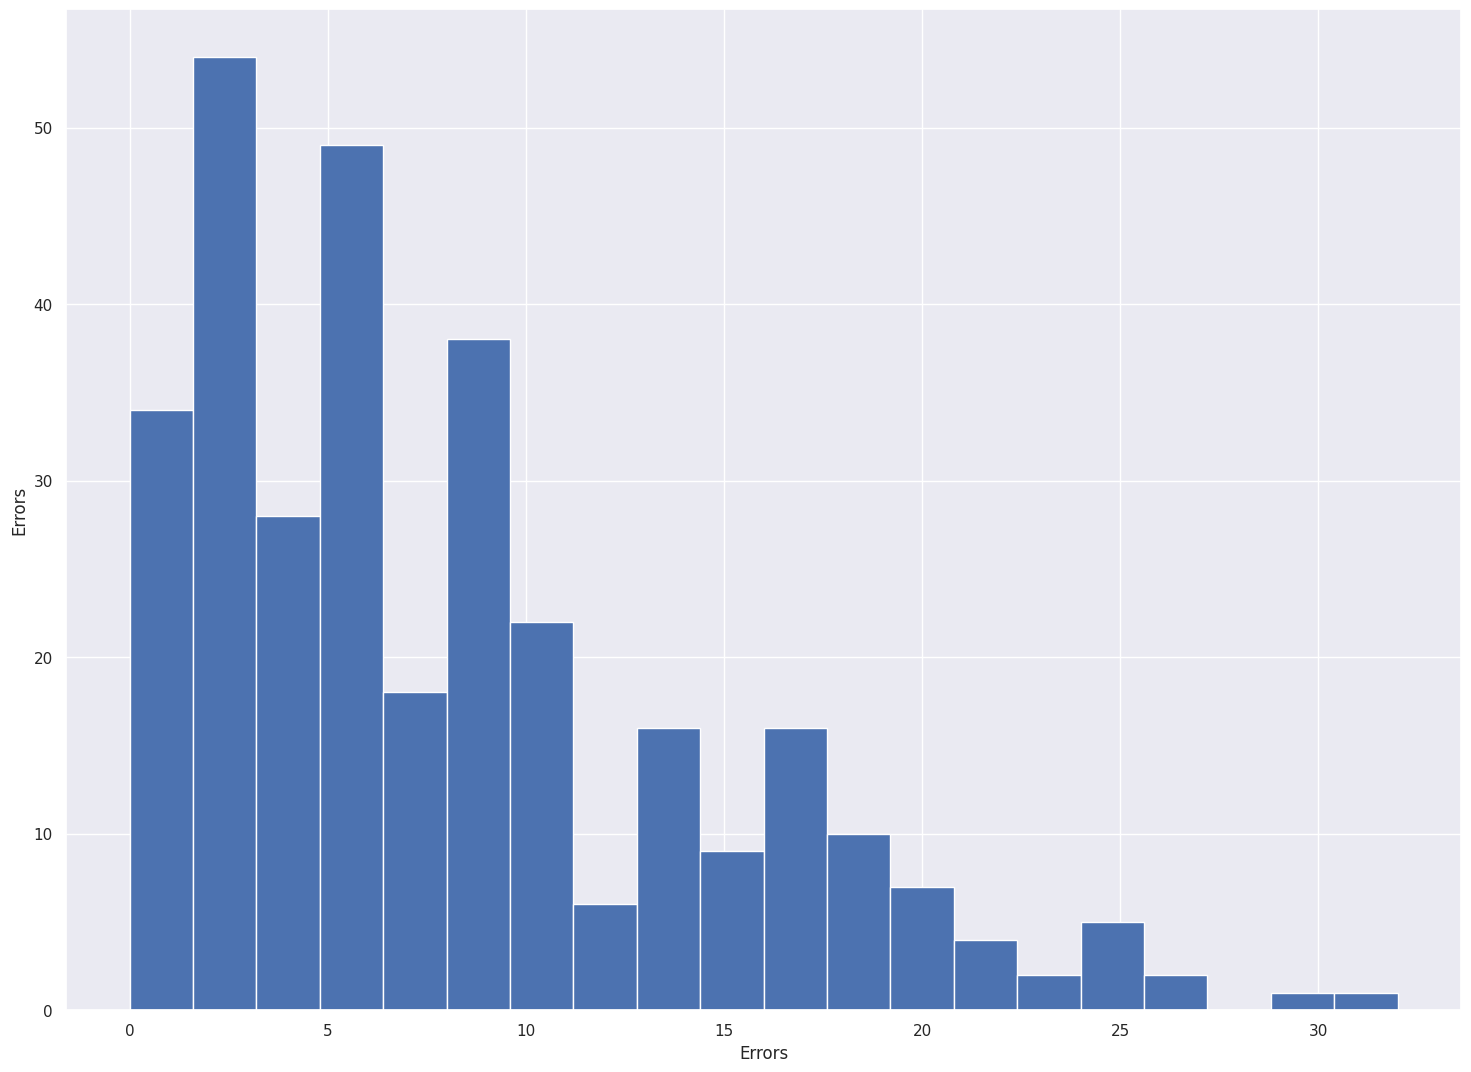

#################### Salary ####################
count     263.000000
mean      535.925882
std       451.118681
min        67.500000
1%         70.000000
5%         86.600000
10%       100.000000
20%       155.000000
30%       221.000000
40%       300.000000
50%       425.000000
60%       538.000000
70%       700.000000
80%       809.000000
90%      1048.666600
95%      1346.000000
99%      2032.886540
max      2460.000000
Name: Salary, dtype: float64


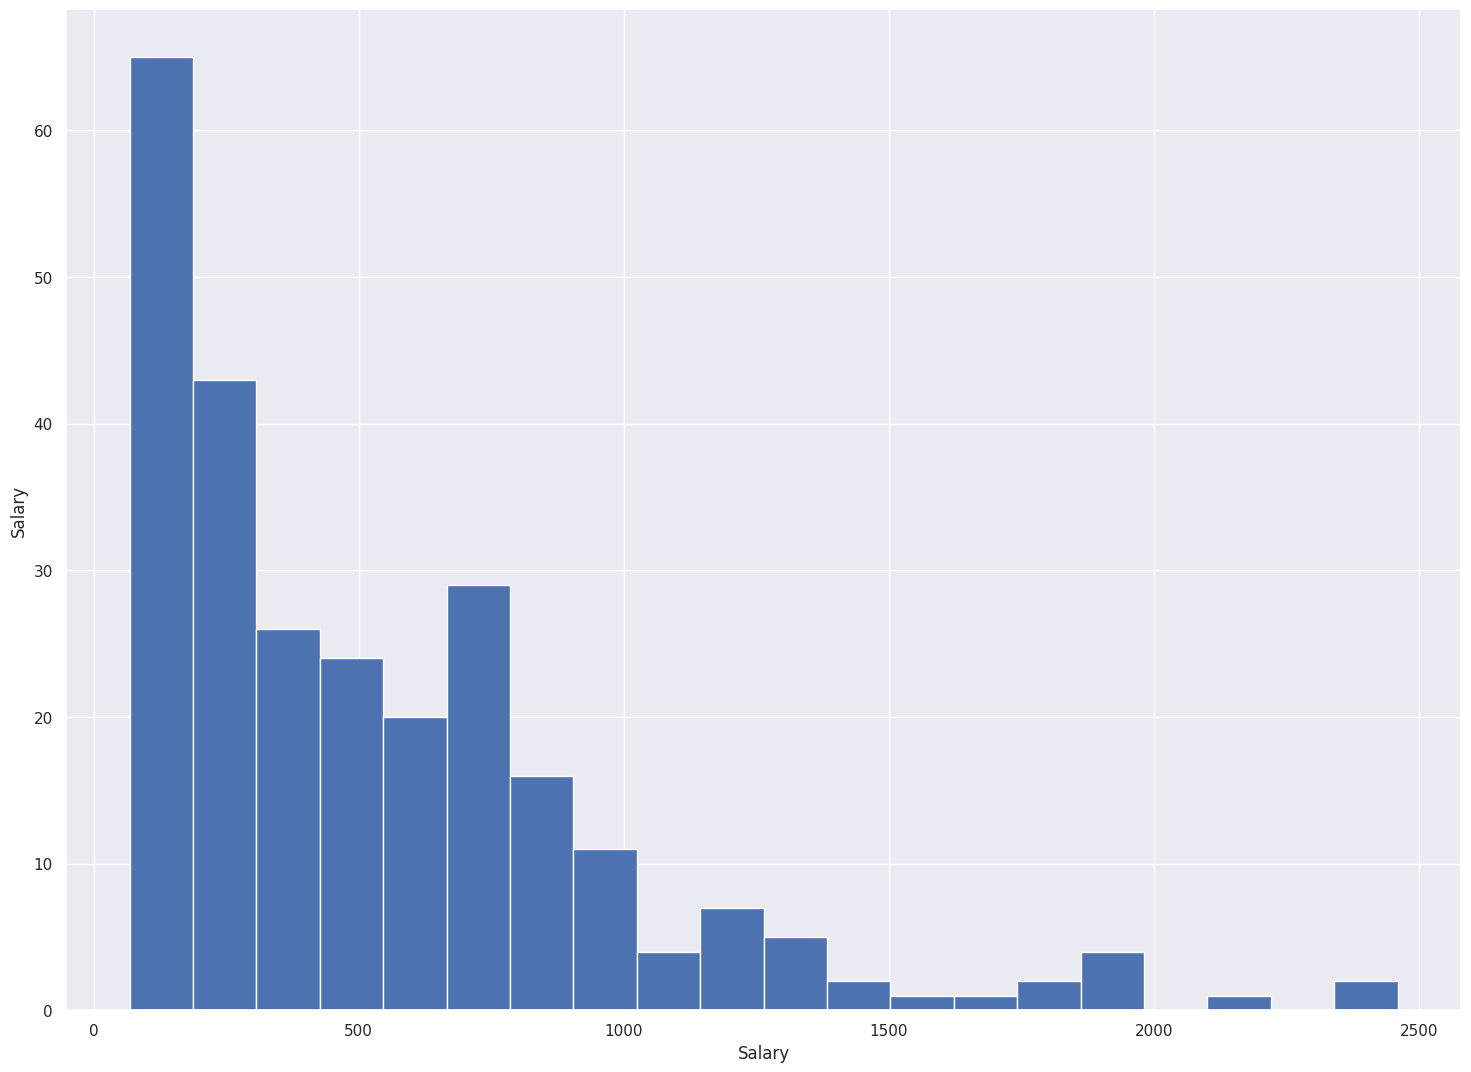

In [ ]:
num_summary_df(df)

In [ ]:
def plot_num_summary(dataframe):
    cat_cols, num_but_cat, cat_but_car, num_cols = grab_col_names(dataframe)
    num_plots = len(num_cols)
    rows = math.ceil(num_plots/2)
    cols = 2 if num_plots > 1 else 1
    plt.figure(figsize=(10*cols, 4*rows))
    for index, col in enumerate(num_cols):
        plt.subplot(rows, cols, index+1)
        plt.tight_layout()
        dataframe[col].hist(bins=20)
        plt.title(col)

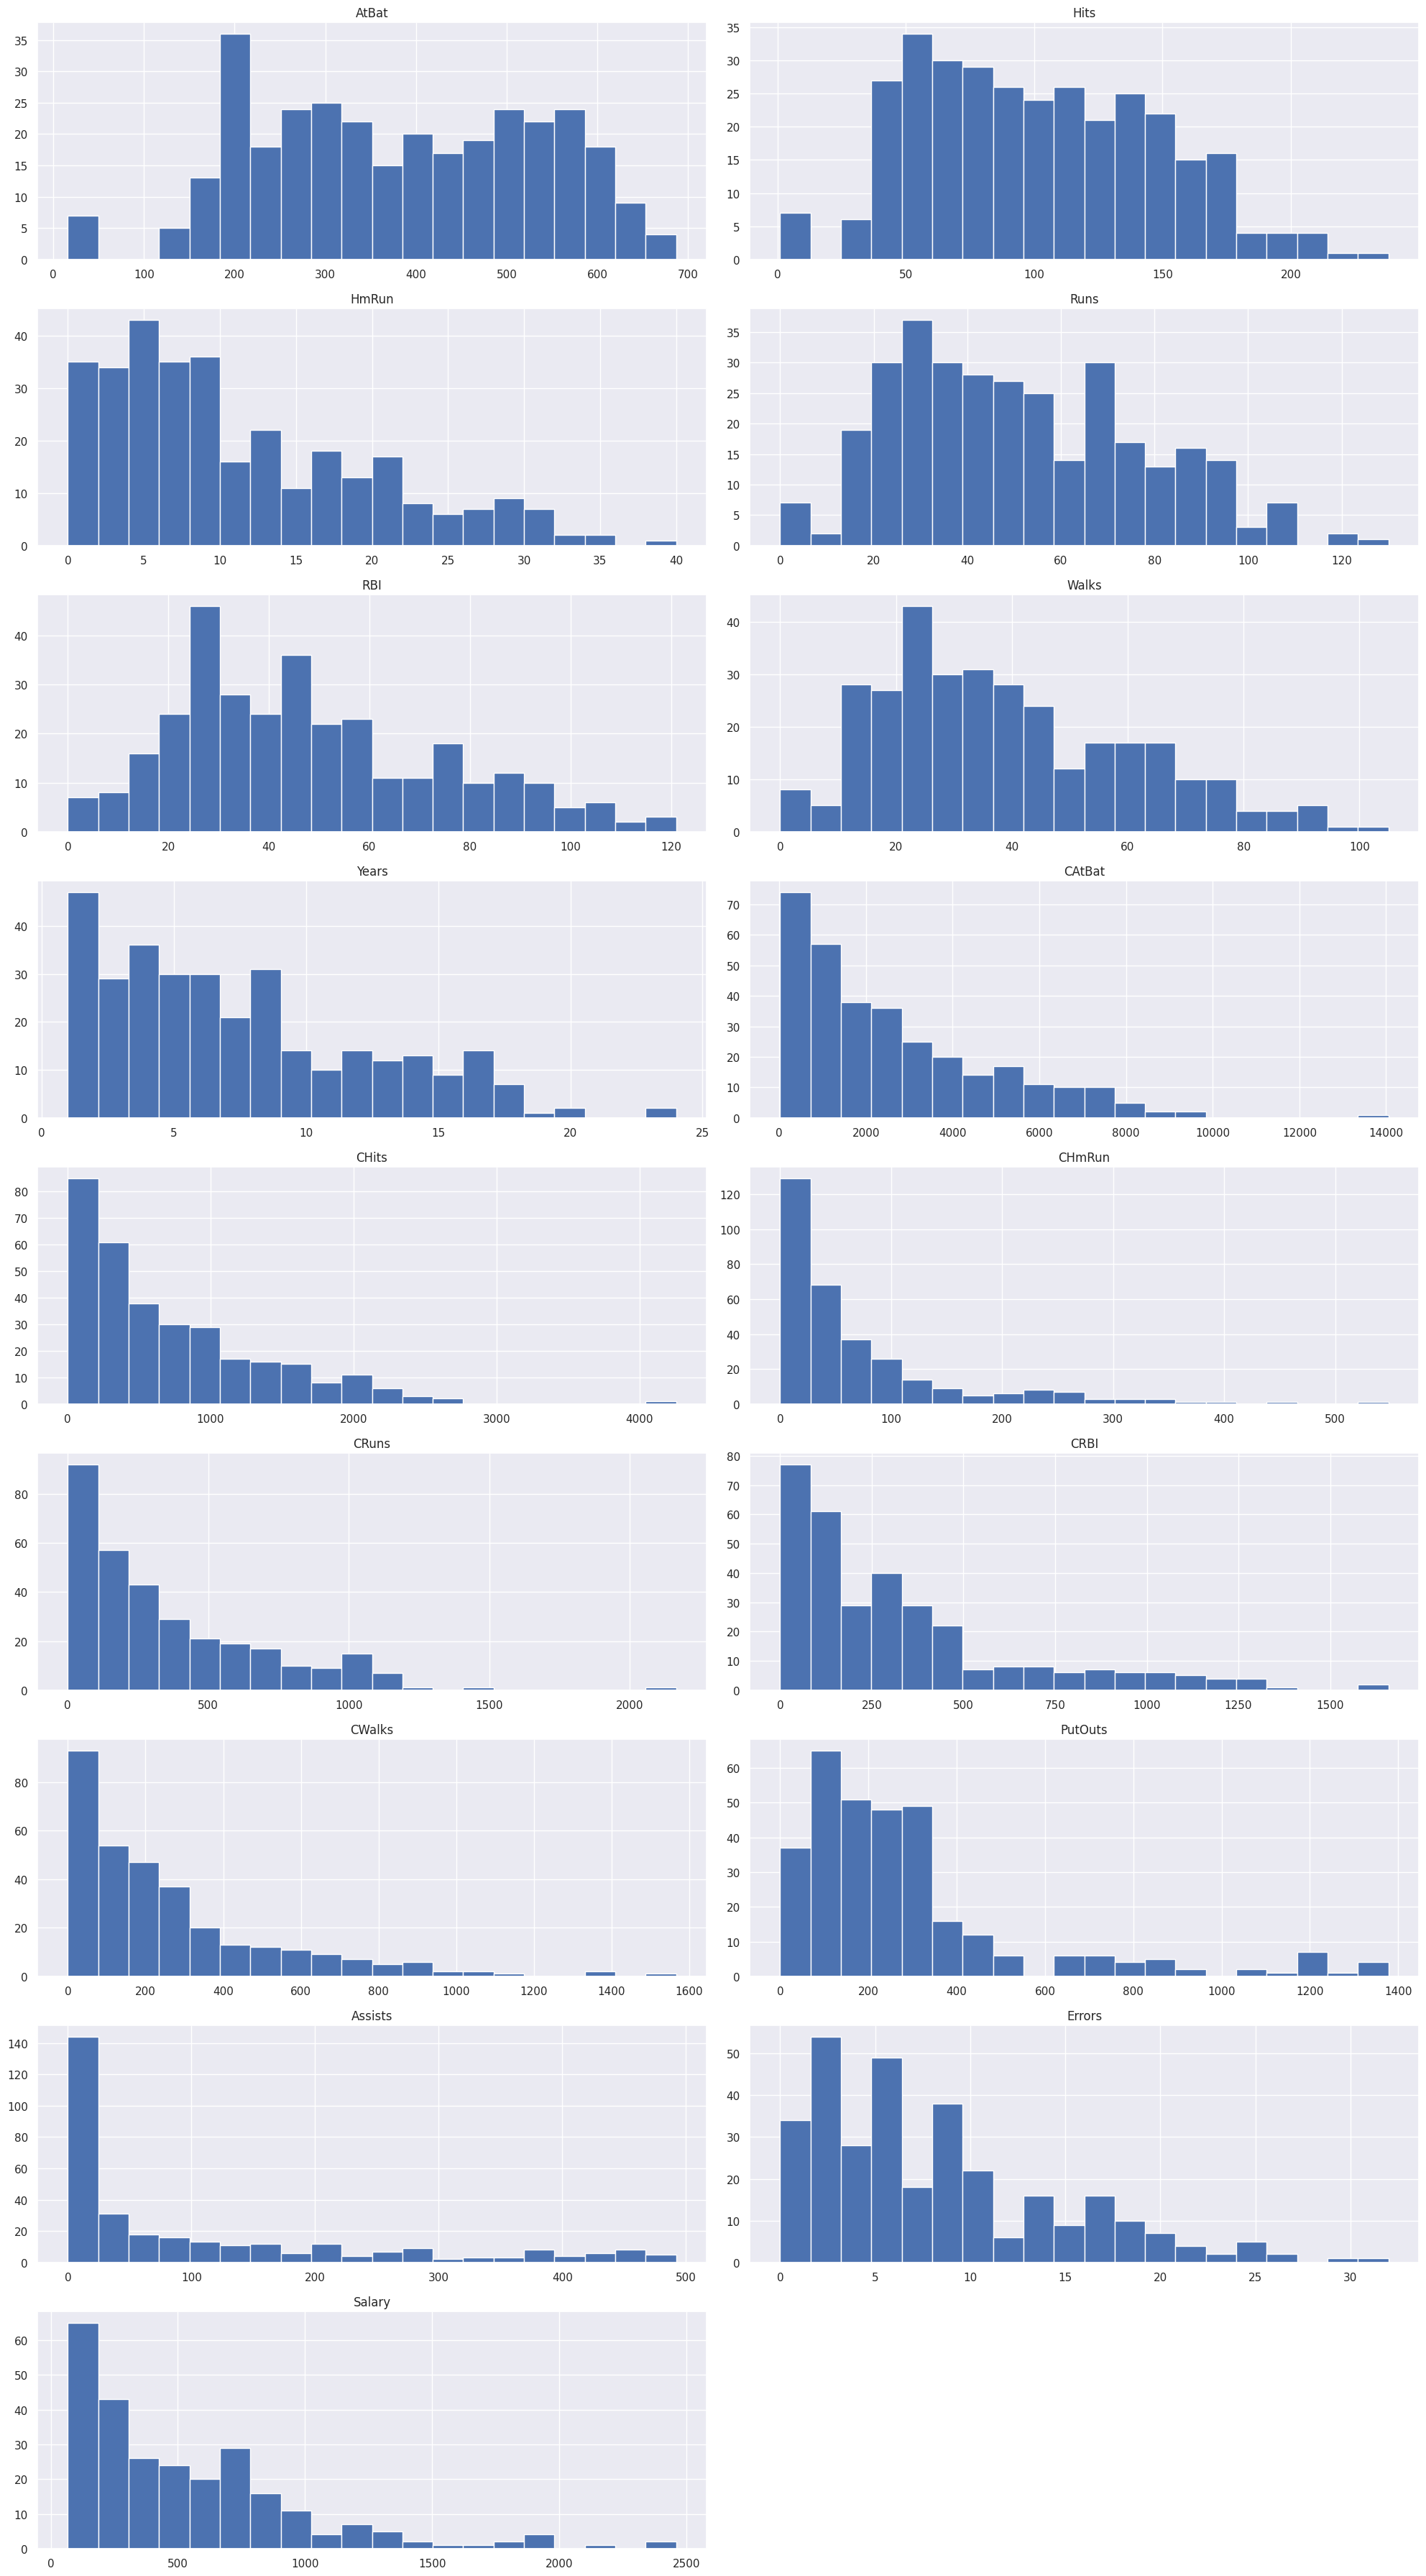

In [ ]:
plot_num_summary(df)

# Correlation Analysis

In [ ]:
def high_correlated_cols(dataframe, corr_th=0.9, remove=False, plot=False):
    num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["uint8", "int64", "float64"]]
    corr = dataframe[num_cols].corr()
    corr_matrix = corr.abs()
    upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if drop_list == []:
        print(20*"#", "After correlation analaysis, you do not need to remove variables", 20*"#")
    if remove:
        dataframe = dataframe.drop(drop_list, axis=1)
    if plot:
        num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["uint8", "int64", "float64"]]
        sns.set(rc={'figure.figsize': (18, 13)})
        sns.heatmap(dataframe[num_cols].corr(), cmap="RdBu", annot=True, fmt=".2f")
        plt.show()
    return drop_list

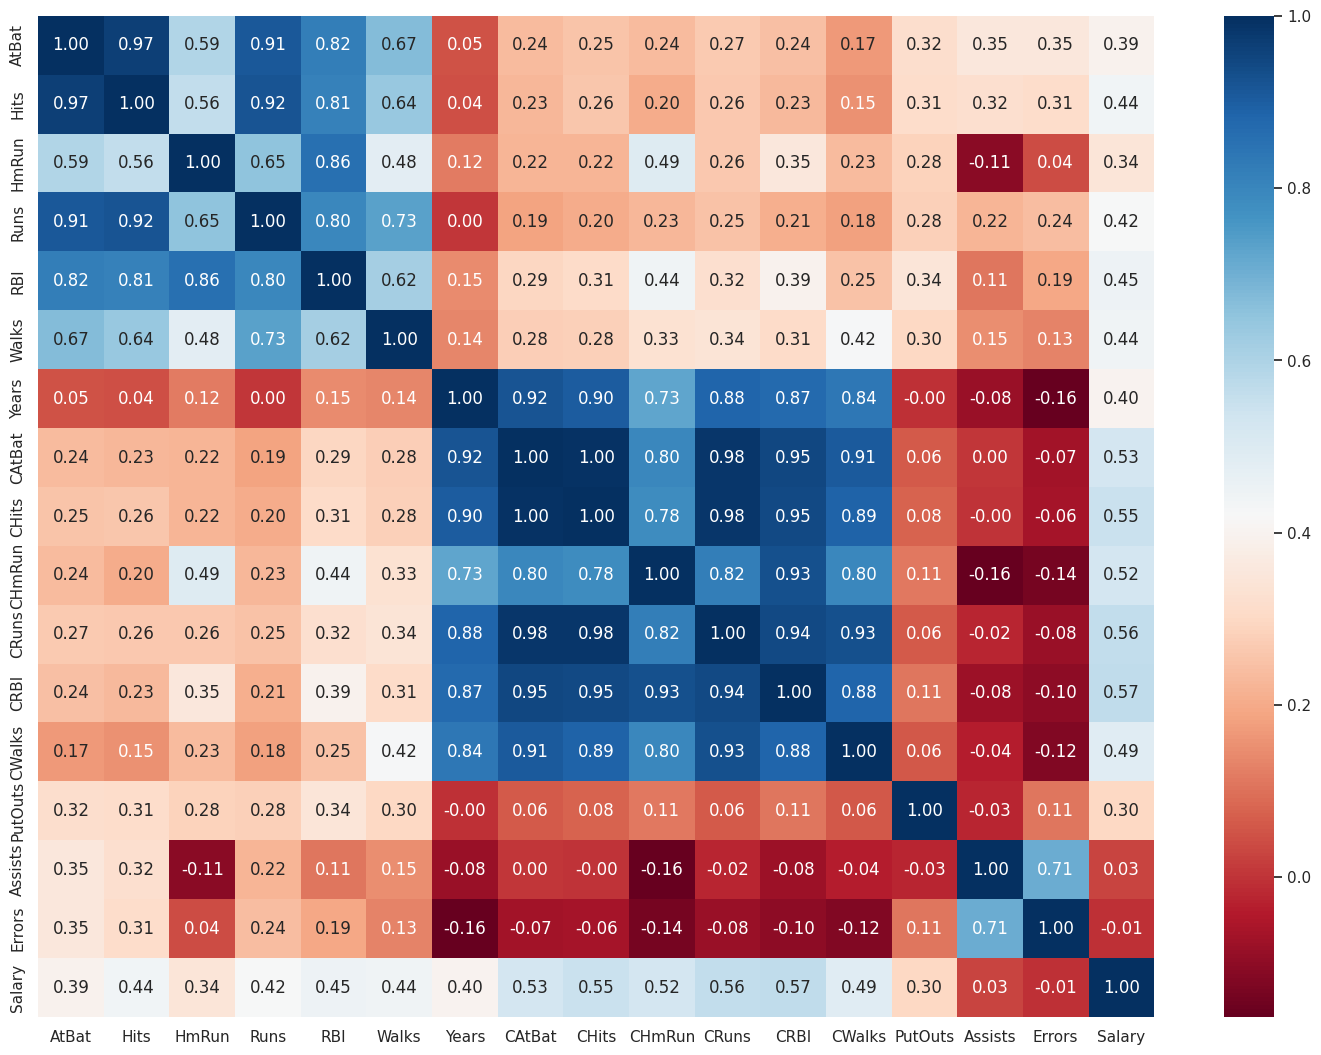

In [ ]:
drop_list = high_correlated_cols(df, remove=False, plot=True)

In [ ]:
drop_list

['Hits', 'Runs', 'CAtBat', 'CHits', 'CRuns', 'CRBI', 'CWalks']

# Missing Value Analysis

In [ ]:
df.isnull().sum()

,0
AtBat,0
Hits,0
HmRun,0
Runs,0
RBI,0
Walks,0
Years,0
CAtBat,0
CHits,0
CHmRun,0


In [ ]:
def missing_value_table(dataframe):
  na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
  n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
  ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
  missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=["n_miss", "ratio"])
  print(missing_df)

In [ ]:
missing_value_table(df)

        n_miss  ratio
Salary      59  18.32


In [ ]:
def fill_na_with_median(dataframe):
  dataframe = dataframe.apply(lambda x: x.fillna(x.median()) if x.dtype not in ["category", "object", "bool"] else x, axis=0)
  return dataframe

In [ ]:
df = fill_na_with_median(df)

In [ ]:
df.isnull().sum().sum()

np.int64(0)

# Encoding

In [ ]:
def label_encoder(dataframe, binary_col):
  labelencoder = LabelEncoder()
  dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
  return dataframe

In [ ]:
def label_encoder_df(dataframe):
  binary_cols = [col for col in dataframe.columns if dataframe[col].dtype not in ["int", "float"] and dataframe[col].nunique() == 2]
  for col in binary_cols:
    label_encoder(dataframe, col)
  return dataframe

In [ ]:
def one_hot_encoding(dataframe):
  cat_cols = [col for col in dataframe.columns if  10 >= dataframe[col].nunique() > 2]
  dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True)
  label_encoder_df(dataframe)
  return dataframe

In [ ]:
df = one_hot_encoding(df)

In [ ]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,0,0,446,33,20,425.0,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1,1,632,43,10,475.0,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0,1,880,82,14,480.0,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1,0,200,11,3,500.0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1,0,805,40,4,91.5,1


# CART

In [ ]:
X = df.drop("Salary", axis=1)
y = df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
cart_model = DecisionTreeRegressor().fit(X_train, y_train)

In [ ]:
cart_model.feature_importances_

array([0.16830626, 0.10336023, 0.04312579, 0.01020209, 0.04234045,
       0.03664375, 0.07354746, 0.02104166, 0.33758061, 0.09446201,
       0.00225874, 0.01824128, 0.00546965, 0.00386232, 0.00331277,
       0.01194744, 0.00801005, 0.00770261, 0.00858483])

In [ ]:
feature_imp = pd.DataFrame({'Value': cart_model.feature_importances_, 'Feature': X.columns}).sort_values(by="Value", ascending=False)

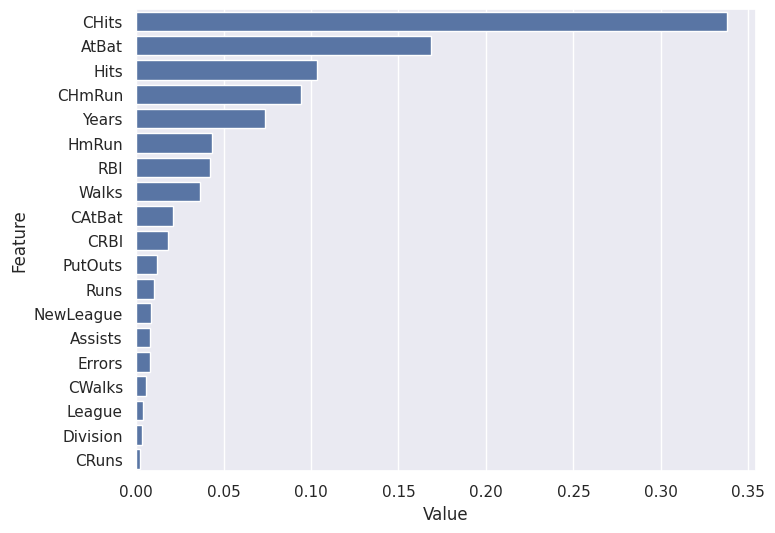

In [ ]:
plt.figure(figsize=(8,6))
sns.barplot(x="Value", y="Feature", data=feature_imp)
plt.show()

In [ ]:
tree_str = export_graphviz(cart_model, feature_names=X.columns, filled=True)

In [ ]:
graph = pydotplus.graph_from_dot_data(tree_str)

In [ ]:
graph.write_png("cart_tree_graph.png")

True

In [ ]:
tree_rules = export_text(cart_model, feature_names=list(X.columns))

In [ ]:
print(tree_rules)

|--- CHits <= 439.00
|   |--- Hits <= 1.50
|   |   |--- value: [2127.33]
|   |--- Hits >  1.50
|   |   |--- CAtBat <= 23.50
|   |   |   |--- value: [920.00]
|   |   |--- CAtBat >  23.50
|   |   |   |--- CHits <= 227.50
|   |   |   |   |--- CHits <= 38.00
|   |   |   |   |   |--- value: [425.00]
|   |   |   |   |--- CHits >  38.00
|   |   |   |   |   |--- RBI <= 20.00
|   |   |   |   |   |   |--- RBI <= 11.50
|   |   |   |   |   |   |   |--- Years <= 3.50
|   |   |   |   |   |   |   |   |--- CRBI <= 23.50
|   |   |   |   |   |   |   |   |   |--- CRuns <= 24.00
|   |   |   |   |   |   |   |   |   |   |--- value: [75.00]
|   |   |   |   |   |   |   |   |   |--- CRuns >  24.00
|   |   |   |   |   |   |   |   |   |   |--- value: [70.00]
|   |   |   |   |   |   |   |   |--- CRBI >  23.50
|   |   |   |   |   |   |   |   |   |--- value: [90.00]
|   |   |   |   |   |   |   |--- Years >  3.50
|   |   |   |   |   |   |   |   |--- PutOuts <= 146.00
|   |   |   |   |   |   |   |   |   |--- value: [

In [ ]:
skompile(cart_model.predict).to('python/code')

'((2127.333 if x[1] <= 1.5 else 920.0 if x[7] <= 23.5 else (425.0 if x[8] <=\n    38.0 else ((((75.0 if x[10] <= 24.0 else 70.0) if x[11] <= 23.5 else \n    90.0) if x[6] <= 3.5 else 175.0 if x[15] <= 146.0 else 190.0) if x[4] <=\n    11.5 else (425.0 if x[16] <= 2.5 else (70.0 if x[3] <= 22.0 else 68.0) if\n    x[6] <= 2.5 else 180.0) if x[13] <= 0.5 else 425.0 if x[7] <= 813.5 else\n    225.0 if x[2] <= 1.5 else 286.667) if x[4] <= 20.0 else 425.0 if x[1] <=\n    31.5 else ((((((95.0 if x[15] <= 74.5 else 100.0) if x[2] <= 4.5 else \n    90.0) if x[5] <= 20.0 else ((67.5 if x[10] <= 26.0 else 70.0) if x[14] <=\n    0.5 else 75.0) if x[3] <= 33.0 else 87.5 if x[2] <= 3.5 else 86.5) if x\n    [8] <= 144.5 else 135.0 if x[10] <= 69.0 else 140.0) if x[7] <= 807.5 else\n    250.0) if x[4] <= 28.5 else (425.0 if x[5] <= 18.5 else (90.0 if x[12] <=\n    32.0 else 110.0) if x[3] <= 34.0 else 425.0) if x[7] <= 326.5 else (((\n    130.0 if x[9] <= 0.5 else 150.0) if x[9] <= 1.5 else (75.0 if x

In [ ]:
skompile(cart_model.predict).to('excel')

ExcelCode([('A1',
            'IF((x9<=439.0),IF((x2<=1.5),2127.333,IF((x8<=23.5),920.0,IF((x9<=227.5),IF((x9<=38.0),425.0,IF((x5<=20.0),IF((x5<=11.5),IF((x7<=3.5),IF((x12<=23.5),IF((x11<=24.0),75.0,70.0),90.0),IF((x16<=146.0),175.0,190.0)),IF((x14<=0.5),IF((x17<=2.5),425.0,IF((x7<=2.5),IF((x4<=22.0),70.0,68.0),180.0)),IF((x8<=813.5),425.0,IF((x3<=1.5),225.0,286.667)))),IF((x2<=31.5),425.0,IF((x10<=27.5),IF((x5<=28.5),IF((x8<=807.5),IF((x9<=144.5),IF((x6<=20.0),IF((x3<=4.5),IF((x16<=74.5),95.0,100.0),90.0),IF((x4<=33.0),IF((x15<=0.5),IF((x11<=26.0),67.5,70.0),75.0),IF((x3<=3.5),87.5,86.5))),IF((x11<=69.0),135.0,140.0)),250.0),IF((x8<=326.5),IF((x6<=18.5),425.0,IF((x4<=34.0),IF((x13<=32.0),90.0,110.0),425.0)),IF((x9<=171.0),IF((x12<=72.5),IF((x10<=1.5),IF((x10<=0.5),130.0,150.0),IF((x6<=19.0),IF((x10<=15.0),75.0,90.0),IF((x8<=630.5),IF((x16<=146.5),125.0,IF((x9<=106.0),IF((x13<=33.5),97.5,100.0),IF((x11<=60.0),IF((x11<=57.0),115.0,120.0),IF((x1<=436.0),110.0,105.0)))),80.0))),IF((x7<=6.

In [ ]:
def CART_Model(dataframe, target,  test_size=0.20, results=False,save_model=False, plot_importance=False,tree_graph = False, tree_rules=False, export_rules="python"):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  cart_model = DecisionTreeRegressor().fit(X_train, y_train)

  if results:
    mse_train = mean_squared_error(y_train, cart_model.predict(X_train))
    mse_test = mean_squared_error(y_test, cart_model.predict(X_test))
    rmse_train = root_mean_squared_error(y_train, cart_model.predict(X_train))
    rmse_test = root_mean_squared_error(y_test, cart_model.predict(X_test))
    mae_train = mean_absolute_error(y_train, cart_model.predict(X_train))
    mae_test = mean_absolute_error(y_test, cart_model.predict(X_test))
    r2_train = r2_score(y_train, cart_model.predict(X_train))
    r2_test = r2_score(y_test, cart_model.predict(X_test))
    print("MSE Train: ", "%.3f" % mse_train)
    print("MSE Test: ", "%.3f" % mse_test)
    print("RMSE Train: ", "%.3f" % rmse_train)
    print("RMSE Test: ", "%.3f" % rmse_test)
    print("MAE Train: ", "%.3f" % mae_train)
    print("MAE Test: ", "%.3f" % mae_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)

  if save_model:
    joblib.dump(cart_model, "cart_model.pkl")

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': cart_model.feature_importances_, 'Feature': X.columns}).sort_values(by="Value", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.savefig("importance.png")
    plt.show()

  if tree_graph:
    tree_str = export_graphviz(cart_model, feature_names=X.columns, filled=True)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png("cart_tree_graph.png")

  if tree_rules:
    tree_rules = export_text(cart_model, feature_names=list(X.columns))
    print(tree_rules)

  if export_rules:
    if export_rules == "python":
      rules = skompile(cart_model.predict).to('python/code')
      print(rules)
    elif export_rules == "excel":
      rules = skompile(cart_model.predict).to('excel')
      print(rules)
    else:
      print("Error in expoert rules")

  return cart_model

MSE Train:  0.000
MSE Test:  186996.350
RMSE Train:  0.000
RMSE Test:  432.431
MAE Train:  0.000
MAE Test:  266.122
R2 Train:  1.000
R2 Test:  0.224


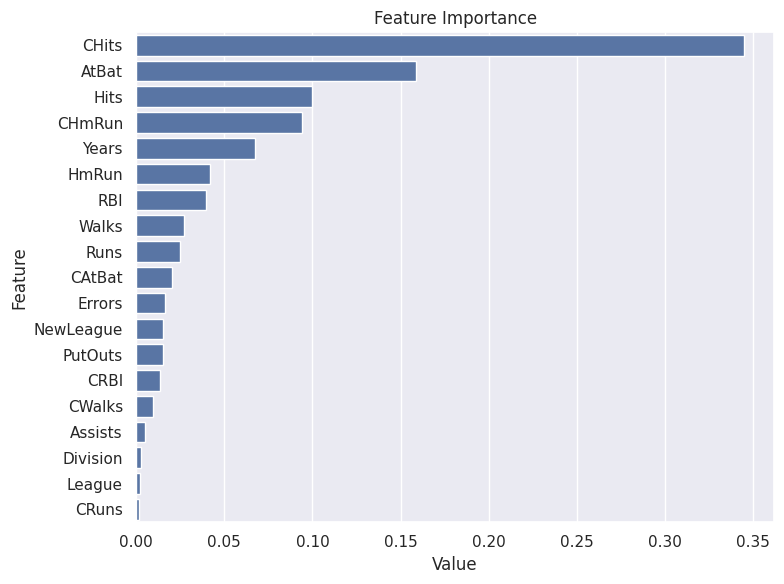

|--- CHits <= 439.00
|   |--- Hits <= 1.50
|   |   |--- value: [2127.33]
|   |--- Hits >  1.50
|   |   |--- CAtBat <= 23.50
|   |   |   |--- value: [920.00]
|   |   |--- CAtBat >  23.50
|   |   |   |--- CHits <= 227.50
|   |   |   |   |--- CHits <= 38.00
|   |   |   |   |   |--- value: [425.00]
|   |   |   |   |--- CHits >  38.00
|   |   |   |   |   |--- RBI <= 20.00
|   |   |   |   |   |   |--- RBI <= 11.50
|   |   |   |   |   |   |   |--- Errors <= 8.00
|   |   |   |   |   |   |   |   |--- CRBI <= 23.50
|   |   |   |   |   |   |   |   |   |--- Walks <= 18.50
|   |   |   |   |   |   |   |   |   |   |--- value: [75.00]
|   |   |   |   |   |   |   |   |   |--- Walks >  18.50
|   |   |   |   |   |   |   |   |   |   |--- value: [70.00]
|   |   |   |   |   |   |   |   |--- CRBI >  23.50
|   |   |   |   |   |   |   |   |   |--- value: [90.00]
|   |   |   |   |   |   |   |--- Errors >  8.00
|   |   |   |   |   |   |   |   |--- Assists <= 89.50
|   |   |   |   |   |   |   |   |   |--- value: 

In [ ]:
cart_model = CART_Model(df, "Salary",  test_size=0.20, results=True,save_model=True, plot_importance=True, tree_graph=True, tree_rules=True, export_rules="excel")

# Load and Prediction New Data

In [ ]:
X = df.drop("Salary", axis=1)
y = df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
cart_model = DecisionTreeRegressor().fit(X_train, y_train)

In [ ]:
skompile(cart_model.predict).to('python/code')

'((2127.333 if x[1] <= 1.5 else 920.0 if x[7] <= 23.5 else (425.0 if x[7] <=\n    173.5 else ((((75.0 if x[12] <= 21.0 else 70.0) if x[4] <= 10.0 else \n    90.0) if x[17] <= 8.0 else 190.0 if x[17] <= 12.5 else 175.0) if x[4] <=\n    11.5 else (425.0 if x[17] <= 0.5 else (68.0 if x[4] <= 16.0 else 70.0) if\n    x[16] <= 15.5 else 180.0) if x[18] <= 0.5 else 425.0 if x[8] <= 209.5 else\n    225.0 if x[9] <= 10.5 else 286.667) if x[4] <= 20.0 else 425.0 if x[1] <=\n    31.5 else (((((90.0 if x[10] <= 37.5 else 95.0 if x[17] <= 5.5 else \n    100.0) if x[5] <= 20.0 else ((70.0 if x[6] <= 1.5 else 67.5) if x[14] <=\n    0.5 else 75.0) if x[3] <= 33.0 else 87.5 if x[18] <= 0.5 else 86.5) if \n    x[8] <= 144.5 else 135.0 if x[5] <= 16.0 else 140.0) if x[12] <= 74.0 else\n    250.0) if x[4] <= 28.5 else (((90.0 if x[0] <= 243.5 else 110.0) if x[0\n    ] <= 290.5 else 425.0) if x[17] <= 4.0 else 425.0) if x[7] <= 326.5 else\n    (((130.0 if x[7] <= 532.5 else 150.0) if x[2] <= 1.0 else (75.0

In [ ]:
def predict_with_rules(x):
  return ((2127.333 if x[3] <= 0.5 else 920.0 if x[7] <= 23.5 else (425.0 if x[7] <=
    173.5 else (((175.0 if x[13] <= 0.5 else 190.0) if x[5] <= 15.5 else (
    70.0 if x[15] <= 204.0 else 75.0) if x[9] <= 4.5 else 90.0) if x[4] <=
    11.5 else (425.0 if x[8] <= 46.5 else (70.0 if x[1] <= 52.5 else 68.0) if
    x[4] <= 18.5 else 180.0) if x[18] <= 0.5 else 425.0 if x[12] <= 61.5 else
    286.667 if x[10] <= 111.5 else 225.0) if x[4] <= 20.0 else 425.0 if x[1
    ] <= 31.5 else ((((((100.0 if x[2] <= 2.0 else 95.0) if x[4] <= 24.5 else
    90.0) if x[5] <= 20.0 else ((67.5 if x[3] <= 23.5 else 70.0) if x[14] <=
    0.5 else 75.0) if x[3] <= 33.0 else 86.5 if x[15] <= 183.0 else 87.5) if
    x[8] <= 144.5 else 140.0 if x[11] <= 68.0 else 135.0) if x[7] <= 807.5 else
    250.0) if x[4] <= 28.5 else (425.0 if x[4] <= 34.0 else (90.0 if x[5] <=
    32.0 else 110.0) if x[11] <= 42.0 else 425.0) if x[7] <= 326.5 else (((
    130.0 if x[11] <= 44.0 else 150.0) if x[9] <= 1.5 else ((125.0 if x[15] <=
    146.5 else (97.5 if x[12] <= 33.5 else 100.0) if x[8] <= 106.0 else (
    105.0 if x[11] <= 42.5 else 110.0) if x[15] <= 325.0 else 120.0 if x[4] <=
    39.0 else 115.0) if x[6] <= 4.0 else 80.0) if x[17] <= 9.5 else 75.0 if
    x[4] <= 50.5 else 90.0) if x[11] <= 72.5 else 175.0 if x[17] <= 4.5 else
    137.0 if x[2] <= 13.0 else 135.0) if x[8] <= 171.0 else ((((202.5 if x[
    5] <= 59.0 else 200.0) if x[5] <= 60.5 else 195.0) if x[2] <= 16.5 else
    185.0) if x[4] <= 88.5 else 165.0) if x[17] <= 20.0 else 105.0 if x[15] <=
    167.5 else 155.0) if x[9] <= 27.5 else 425.0 if x[7] <= 649.0 else (
    145.0 if x[4] <= 88.5 else 165.0) if x[10] <= 101.5 else (247.5 if x[17
    ] <= 6.0 else 215.0) if x[13] <= 0.5 else 265.0 if x[4] <= 49.5 else
    300.0) if x[8] <= 227.5 else (425.0 if x[3] <= 23.0 else (((((215.0 if
    x[16] <= 188.0 else 230.0) if x[16] <= 206.0 else 275.0 if x[18] <= 0.5
     else 250.0) if x[2] <= 7.5 else 150.0) if x[12] <= 85.0 else 425.0) if
    x[10] <= 126.0 else (((210.0 if x[16] <= 61.5 else 215.0) if x[4] <=
    104.0 else 200.0) if x[10] <= 197.0 else 240.0 if x[9] <= 36.5 else
    250.0) if x[17] <= 17.0 else 160.0 if x[2] <= 1.5 else 175.0) if x[12] <=
    136.0 else 277.5 if x[5] <= 33.5 else 350.0 if x[2] <= 5.0 else 340.0) if
    x[6] <= 4.5 else (((425.0 if x[15] <= 372.0 else 300.0) if x[3] <= 27.0
     else ((250.0 if x[11] <= 110.5 else 190.0) if x[12] <= 111.5 else ((
    297.5 if x[11] <= 173.0 else 300.0) if x[6] <= 5.5 else 305.0) if x[5] <=
    44.0 else 350.0) if x[4] <= 48.5 else 385.0 if x[18] <= 0.5 else 415.0) if
    x[8] <= 355.0 else (((425.0 if x[10] <= 242.5 else 400.0) if x[6] <=
    5.5 else 475.0) if x[4] <= 68.5 else 550.0) if x[15] <= 572.0 else
    700.0) if x[2] <= 25.0 else 100.0) if x[8] <= 439.0 else (((((700.0 if
    x[7] <= 3013.5 else 900.0) if x[2] <= 4.5 else 425.0) if x[4] <= 16.0 else
    (670.0 if x[10] <= 252.5 else (((737.5 if x[11] <= 489.0 else 600.0) if
    x[4] <= 34.0 else 425.0) if x[16] <= 6.5 else 235.0 if x[5] <= 7.5 else
    (((425.0 if x[9] <= 47.0 else 450.0) if x[6] <= 18.5 else 500.0) if x[4
    ] <= 38.0 else 525.0) if x[17] <= 6.5 else 425.0 if x[4] <= 23.0 else (
    341.667 if x[0] <= 299.5 else 320.0) if x[5] <= 29.0 else 250.0) if x[2
    ] <= 5.5 else ((325.0 if x[16] <= 1.5 else 275.0 if x[14] <= 0.5 else
    260.0) if x[0] <= 309.5 else 100.0) if x[5] <= 22.5 else ((240.0 if x[1
    ] <= 73.0 else 325.0) if x[12] <= 253.5 else 365.0 if x[0] <= 232.5 else
    (430.0 if x[7] <= 5058.5 else 425.0) if x[5] <= 41.5 else 450.0) if x[7
    ] <= 7869.5 else 200.0) if x[5] <= 43.5 else 425.0 if x[11] <= 1023.5 else
    1050.0) if x[4] <= 56.5 else (750.0 if x[9] <= 100.5 else 850.0) if x[0
    ] <= 399.0 else 487.5) if x[15] <= 221.0 else ((((560.0 if x[1] <=
    115.0 else 600.0) if x[15] <= 255.0 else 650.0 if x[0] <= 345.5 else
    675.0) if x[10] <= 826.5 else 425.0) if x[15] <= 320.5 else 250.0 if x[
    4] <= 23.5 else 500.0 if x[12] <= 193.0 else 425.0 if x[16] <= 48.0 else
    400.0) if x[18] <= 0.5 else 1300.0 if x[0] <= 234.5 else (708.333 if x[
    7] <= 2473.0 else 850.0 if x[2] <= 7.5 else 800.0) if x[14] <= 0.5 else
    (875.0 if x[10] <= 1173.0 else 750.0) if x[4] <= 27.5 else 425.0 if x[2
    ] <= 3.0 else 535.0 if x[15] <= 287.0 else 490.0 if x[6] <= 10.5 else
    475.0) if x[0] <= 426.5 else ((((825.0 if x[3] <= 51.5 else 1260.0 if x
    [2] <= 12.5 else 1500.0) if x[0] <= 450.0 else (((((575.0 if x[10] <=
    233.0 else 580.0) if x[2] <= 11.0 else 612.5 if x[18] <= 0.5 else (
    630.0 if x[17] <= 6.5 else 625.0) if x[16] <= 226.0 else 640.0) if x[5] <=
    71.5 else 750.0) if x[7] <= 2035.5 else ((700.0 if x[16] <= 14.0 else
    740.0) if x[4] <= 68.5 else 657.0 if x[15] <= 305.5 else 662.5) if x[17
    ] <= 7.0 else 875.0 if x[1] <= 125.0 else (780.0 if x[12] <= 155.5 else
    775.0) if x[12] <= 176.0 else 750.0) if x[12] <= 229.0 else ((625.0 if
    x[8] <= 690.0 else (750.0 if x[12] <= 306.5 else 765.0) if x[6] <= 9.5 else
    725.0) if x[9] <= 40.0 else 600.0 if x[12] <= 251.5 else 480.0 if x[12] <=
    268.0 else 425.0) if x[1] <= 202.0 else 90.0) if x[11] <= 338.5 else ((
    (((815.0 if x[11] <= 406.5 else 787.5) if x[1] <= 163.5 else 740.0) if
    x[9] <= 117.5 else 940.0 if x[8] <= 881.5 else 950.0) if x[15] <= 590.5
     else (1150.0 if x[2] <= 15.0 else 1183.333) if x[16] <= 102.0 else
    1008.333) if x[4] <= 90.5 else 1220.0 if x[1] <= 154.5 else 1300.0) if
    x[6] <= 7.5 else ((((850.0 if x[12] <= 300.0 else 925.0) if x[11] <=
    443.0 else (737.5 if x[4] <= 50.5 else 740.0) if x[15] <= 222.0 else
    773.333) if x[3] <= 68.0 else 525.0) if x[1] <= 142.5 else (1000.0 if x
    [0] <= 547.5 else 960.0) if x[16] <= 139.0 else 1200.0) if x[4] <= 72.5
     else (277.5 if x[10] <= 356.0 else (500.0 if x[17] <= 16.5 else 530.0 if
    x[8] <= 1070.5 else 517.143) if x[11] <= 513.0 else (420.0 if x[2] <=
    23.5 else 425.0) if x[10] <= 776.0 else 500.0) if x[6] <= 12.0 else (
    587.5 if x[17] <= 4.5 else 425.0) if x[16] <= 109.0 else 850.0 if x[8] <=
    1490.0 else 750.0 if x[12] <= 351.0 else 775.0 if x[0] <= 598.5 else
    776.667) if x[5] <= 96.0 else 1600.0) if x[2] <= 28.5 else (((1175.0 if
    x[15] <= 318.5 else 1237.5) if x[11] <= 425.0 else 1310.0) if x[7] <=
    2839.0 else 900.0 if x[0] <= 616.5 else 1041.667) if x[1] <= 218.0 else
    1975.0) if x[9] <= 256.5 else ((1861.46 if x[18] <= 0.5 else 1900.0) if
    x[5] <= 77.5 else 2460.0) if x[6] <= 14.5 else (875.0 if x[10] <=
    1042.5 else 933.333) if x[10] <= 1110.0 else 1450.0)


In [ ]:
X.sample(1)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague
280,453,103,8,53,33,52,2,507,123,8,63,39,58,0,1,289,407,6,0


In [ ]:
x  = X.sample(1).values.tolist()[0]

In [ ]:
predict_with_rules(x)

1260.0

In [ ]:
new_data = df.sample(1)

In [ ]:
new_data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
51,214,53,2,30,29,23,2,226,59,2,32,32,27,1,0,109,7,3,70.0,1


In [ ]:
new_data = new_data.drop("Salary", axis=1)

In [ ]:
new_data_ready = new_data.values.tolist()[0]

In [ ]:
predict_with_rules(new_data.values.tolist()[0])

425.0

In [ ]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [ ]:
model_disc = load_model("cart_model.pkl")

In [ ]:
model_disc.predict(pd.DataFrame(new_data.values.tolist()[0]).T)[0]

np.float64(425.0)

# CART Model Tuning

In [ ]:
X = df.drop("Salary", axis=1)
y = df["Salary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
cart_model = DecisionTreeRegressor().fit(X_train, y_train)

In [ ]:
X.shape[1]

19

In [ ]:
train_score, test_score =validation_curve(cart_model, X, y,param_name="max_depth", param_range=range(1, X.shape[1]), scoring="neg_mean_squared_error", cv=10)

In [ ]:
train_score

array([[-1.23164371e+05, -1.22475656e+05, -1.07746295e+05,
        -1.06215600e+05, -1.20230635e+05, -1.07395953e+05,
        -1.12599817e+05, -1.13853729e+05, -1.21871801e+05,
        -1.19080892e+05],
       [-8.25399392e+04, -8.71486410e+04, -7.62039287e+04,
        -7.55403637e+04, -8.38999470e+04, -7.45642375e+04,
        -7.69414855e+04, -7.82894478e+04, -8.51940627e+04,
        -8.43329750e+04],
       [-6.00074800e+04, -6.73076889e+04, -5.83368669e+04,
        -5.93796408e+04, -6.58898230e+04, -5.70054604e+04,
        -6.24716843e+04, -5.68994008e+04, -6.64555392e+04,
        -6.26479750e+04],
       [-4.15618564e+04, -4.55528562e+04, -4.04421116e+04,
        -4.62356818e+04, -4.63148399e+04, -3.92717816e+04,
        -4.69945662e+04, -4.32069420e+04, -5.13369308e+04,
        -4.00603121e+04],
       [-2.83834982e+04, -2.92557167e+04, -2.50011728e+04,
        -3.35760245e+04, -3.49091127e+04, -2.60113499e+04,
        -3.47555435e+04, -3.02808886e+04, -3.55396697e+04,
        -2.

In [ ]:
mean_train_score = np.mean(train_score, axis=1)

In [ ]:
mean_test_score = np.mean(test_score, axis=1)

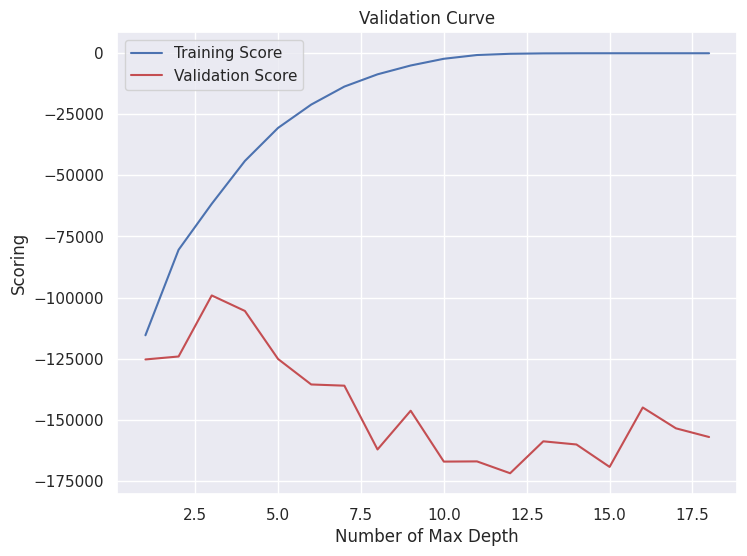

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1, X.shape[1]), mean_train_score, color = "b", label="Training Score")
plt.plot(range(1, X.shape[1]), mean_test_score, color="r", label="Validation Score")
plt.title("Validation Curve")
plt.xlabel("Number of Max Depth")
plt.ylabel("Scoring")
plt.legend()
plt.show()

In [ ]:
def val_curve_params(model, X,y, param_name, param_range,scoring="neg_mean_squared_error", cv=10):
  train_score, test_score =validation_curve(model, X, y,param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)
  mean_train_score = np.mean(train_score, axis=1)
  mean_test_score = np.mean(test_score, axis=1)
  plt.figure(figsize=(8,6))
  plt.plot(param_range, mean_train_score, color = "b", label="Training Score")
  plt.plot(param_range, mean_test_score, color="r", label="Validation Score")
  plt.title(f"Validation Curve for {type(model).__name__}")
  plt.xlabel(f"Number of {param_name}")
  plt.ylabel("Scoring")
  plt.tight_layout()
  plt.legend()
  plt.show()

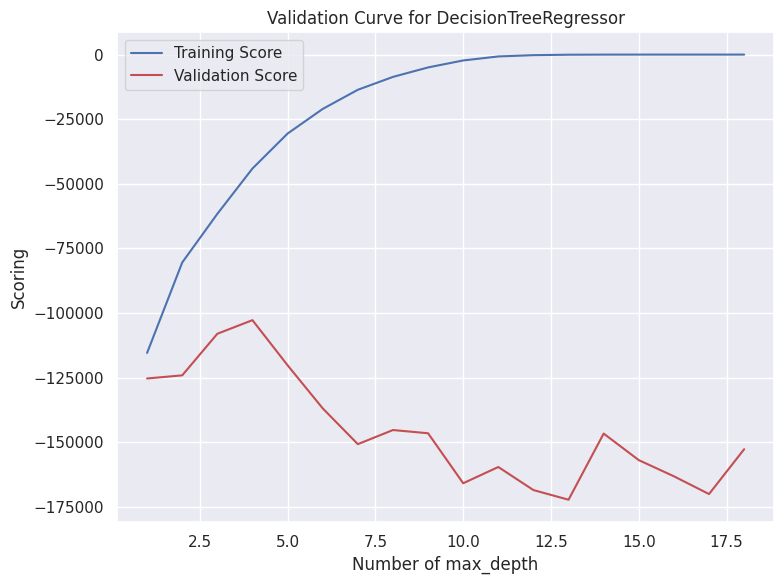

In [ ]:
val_curve_params(cart_model, X,y, param_name="max_depth", param_range=range(1,X.shape[1]),scoring="neg_mean_squared_error", cv=10)

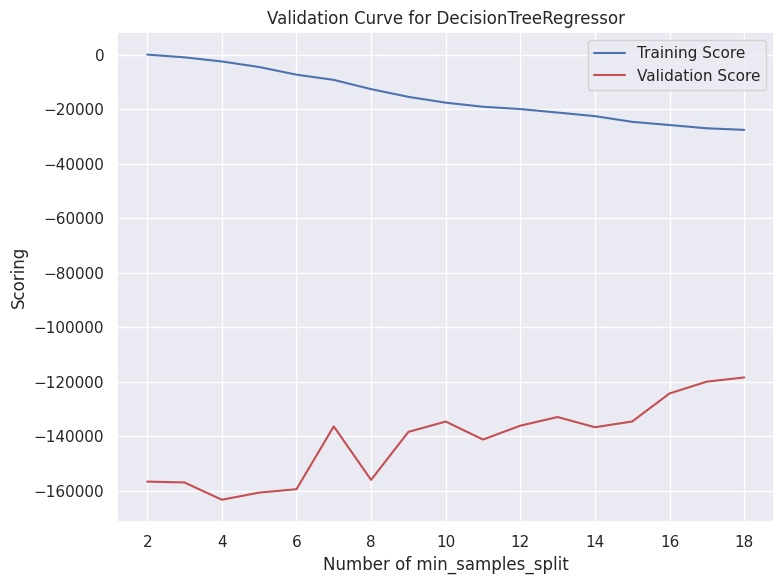

In [ ]:
val_curve_params(cart_model, X,y, param_name="min_samples_split", param_range=range(2,X.shape[1]))

In [ ]:
hiper_params = [["max_depth", range(1,19)], ["min_samples_split", range(1,19)]]

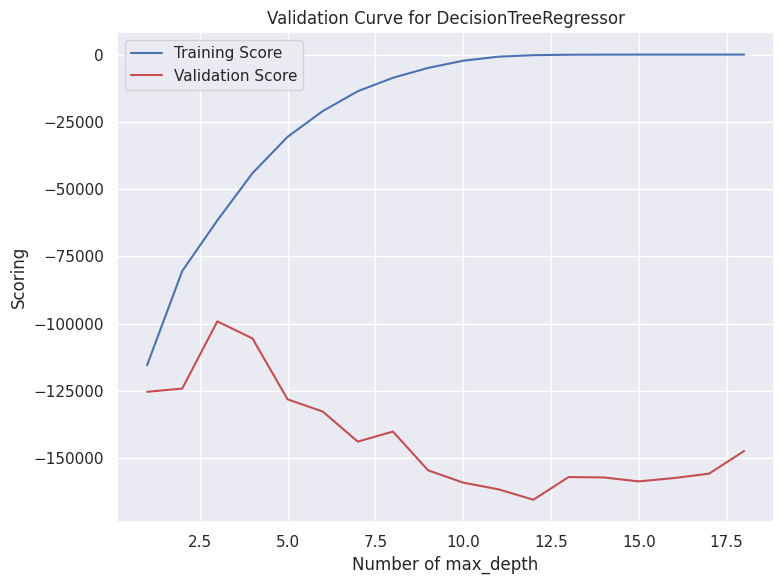

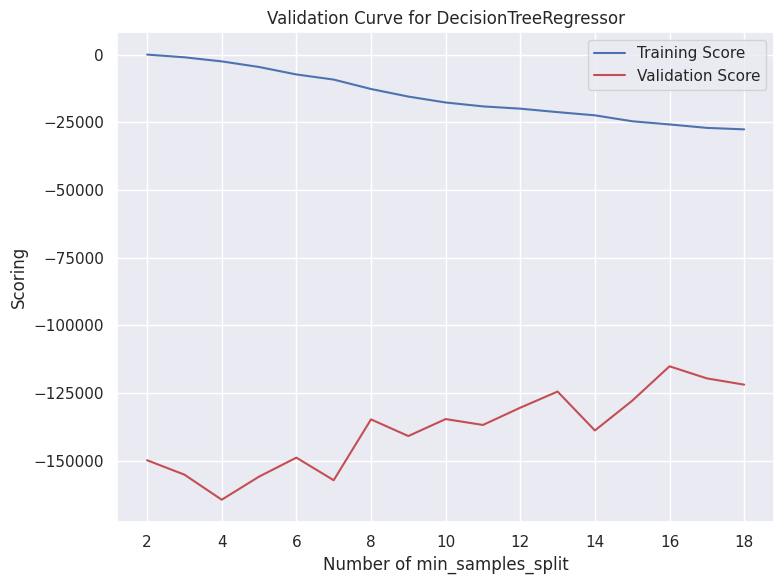

In [ ]:
for i in range(len(hiper_params)):
  val_curve_params(cart_model, X, y, hiper_params[i][0], hiper_params[i][1])

In [ ]:
mse_cv = cross_validate(cart_model, X,y,cv=10, scoring="neg_mean_squared_error")

In [ ]:
mse_cv["test_score"].mean()

np.float64(-151596.87597974128)

In [ ]:
range(1,X.shape[1])

range(1, 19)

In [ ]:
def CART_Model_Tuning(dataframe,target,test_size=0.20,cv=10,results=False,save_model=False,plot_importance=False,tree_graph=False,tree_rules=False,export_rules="python"):
  X = dataframe.drop(target, axis=1)
  y = dataframe[target]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
  cart_model = DecisionTreeRegressor()
  cart_params = {
      "max_depth" : range(1,X.shape[1]), #[3,5,8,15,18,None],
      "max_features" : range(1,X.shape[1]), #[3,5,7,9,12,15,"auto"],
      "min_samples_split" : [11,13,15,17,20]

  }
  cart_cv_model = GridSearchCV(cart_model, cart_params, cv=cv).fit(X_train, y_train)
  cart_model_tuned = cart_model.set_params(**cart_cv_model.best_params_, random_state=1).fit(X,y)

  if results:
    mse_train = mean_squared_error(y_train, cart_model_tuned.predict(X_train))
    mse_test = mean_squared_error(y_test, cart_model_tuned.predict(X_test))
    rmse_train = root_mean_squared_error(y_train, cart_model_tuned.predict(X_train))
    rmse_test = root_mean_squared_error(y_test, cart_model_tuned.predict(X_test))
    mae_train = mean_absolute_error(y_train, cart_model_tuned.predict(X_train))
    mae_test = mean_absolute_error(y_test, cart_model_tuned.predict(X_test))
    r2_train = r2_score(y_train, cart_model_tuned.predict(X_train))
    r2_test = r2_score(y_test, cart_model_tuned.predict(X_test))
    cv_results_mse = cross_validate(cart_model, X, y, cv=cv, scoring="neg_mean_squared_error")
    cv_results_rmse = cross_validate(cart_model, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    print("Best Params: ", cart_cv_model.best_params_)
    print("MSE Train: ", "%.3f" % mse_train)
    print("MSE Test: ", "%.3f" % mse_test)
    print("RMSE Train: ", "%.3f" % rmse_train)
    print("RMSE Test: ", "%.3f" % rmse_test)
    print("MAE Train: ", "%.3f" % mae_train)
    print("MAE Test: ", "%.3f" % mae_test)
    print("R2 Train: ", "%.3f" % r2_train)
    print("R2 Test: ", "%.3f" % r2_test)
    print("Cross Validate MSE Score: ", "%.3f" % cv_results_mse["test_score"].mean())
    print("Cross Validate RMSE Score: ", "%.3f" % cv_results_rmse["test_score"].mean())

  if save_model:
    joblib.dump(cart_model_tuned, "cart_model_tuned.pkl")
    print("Model Saved...")

  if plot_importance:
    feature_imp = pd.DataFrame({'Value': cart_model.feature_importances_, 'Feature': X.columns}).sort_values(by="Value", ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.savefig("importance.png")
    plt.show()

  if tree_graph:
    tree_str = export_graphviz(cart_model_tuned, feature_names=X.columns, filled=True)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png("cart_tree_graph.png")

  if tree_rules:
    tree_rules = export_text(cart_model_tuned, feature_names=list(X.columns))
    print(tree_rules)

  if export_rules:
    if export_rules == "python":
      rules = skompile(cart_model_tuned.predict).to('python/code')
      print(rules)
    elif export_rules == "excel":
      rules = skompile(cart_model_tuned.predict).to('excel')
      print(rules)
    else:
      print("Error in expoert rules")

  return cart_model_tuned

Best Params:  {'max_depth': 4, 'max_features': 8, 'min_samples_split': 11}
MSE Train:  48565.836
MSE Test:  73183.274
RMSE Train:  220.377
RMSE Test:  270.524
MAE Train:  156.688
MAE Test:  158.367
R2 Train:  0.670
R2 Test:  0.696
Cross Validate MSE Score:  -119040.061
Cross Validate RMSE Score:  -328.907
Model Saved...


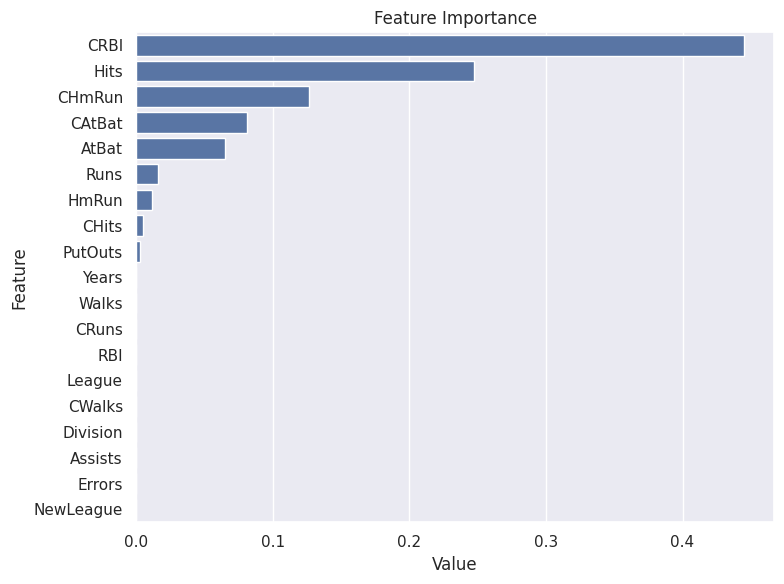

|--- CRBI <= 300.50
|   |--- CAtBat <= 1452.00
|   |   |--- AtBat <= 21.00
|   |   |   |--- value: [974.33]
|   |   |--- AtBat >  21.00
|   |   |   |--- CAtBat <= 699.00
|   |   |   |   |--- value: [170.91]
|   |   |   |--- CAtBat >  699.00
|   |   |   |   |--- value: [295.48]
|   |--- CAtBat >  1452.00
|   |   |--- CHits <= 450.00
|   |   |   |--- PutOuts <= 981.00
|   |   |   |   |--- value: [424.39]
|   |   |   |--- PutOuts >  981.00
|   |   |   |   |--- value: [100.00]
|   |   |--- CHits >  450.00
|   |   |   |--- AtBat <= 371.00
|   |   |   |   |--- value: [448.80]
|   |   |   |--- AtBat >  371.00
|   |   |   |   |--- value: [598.70]
|--- CRBI >  300.50
|   |--- Hits <= 122.50
|   |   |--- Runs <= 81.00
|   |   |   |--- HmRun <= 8.50
|   |   |   |   |--- value: [453.65]
|   |   |   |--- HmRun >  8.50
|   |   |   |   |--- value: [620.03]
|   |   |--- Runs >  81.00
|   |   |   |--- value: [1300.00]
|   |--- Hits >  122.50
|   |   |--- CHmRun <= 256.50
|   |   |   |--- Hits <= 202.50

In [ ]:
cart_model_tuned = CART_Model_Tuning(df,"Salary",cv=15,results=True,save_model=True,plot_importance=True,tree_graph=True,tree_rules=True,export_rules="python")

# Load and Prediction

In [ ]:
def load_model(pklfile):
  model_disc = joblib.load(pklfile)
  return model_disc

In [ ]:
model_disc = load_model("cart_model_tuned.pkl")

In [ ]:
model_disc.predict(pd.DataFrame(new_data.values.tolist()[0]).T)[0]

np.float64(170.9090909090909)